# NLP Climate Research Project

# Readme

# Modular Climate Fact-checking System with Hybrid Retriever and Dual-stream Classfier

## Overview
This project aims to design a 2-stage fact-checking system, containing evidence retrieval and claim verification, for classifying climate science related claims. Our architecture com-
bines classical retrieval methods with
modern deep learning models to balance retrieval
quality and scalability, and supports both fine-tuned
and prompt-based classification strategies.


## Colab Notebook Structure

> 1.DataSet Processing

> 2.Model Implementation
>
>> 2.1  Evidence Retrieval - Trying Different Methods for retrival methods
>>
>>> 2.1.1 BM25 + MiniLM x2 (Bi-encoder) + In-Context Re-ranker
>>
>>> **2.1.2 [Final Method]** BM25 filter + MiniLM-L6 Retriever (Bi-encoder) + Fine-tuned MiniLM-L12 Reranker (Cross-encoder) + In-Context Re-ranker
>
>> 2.2 Modelling Claim Verification as Classification (Method A)
>>
>>>2.2.1 Fine-tuning -- Crosswise Text Input
>>
>>> **2.2.2 [Final Method]** Fine-tuning -- Pairwise Text Input
>>
>>> 2.2.3 Balancing Training Dataset
>
>> 2.3 Modelling Claim Verification as Generation (Method B)
>>
>>> 2.3.1 Evaluation & Error Analysis
>>
>>> 2.3.2 Memory Clean up

> 3.Testing and Evaluation
>
>> 3.1 Processing and Retrieval
>
>> **3.2 [Final Model Implementation]** Classification Model Testing & Evaluation
>>
>>> 3.2.1 Classification Model Test Prediction & Evaluation
>>
>>> 3.2.2 Classfication Model Error Analysis
>
>> 3.3 Generation Task Testing & Evaluation
>>
>>> 3.3.1 Loading In-Context Model and Prompt building
>>
>>> 3.3.2 Inferencing for Test Set

> Object Oriented Programming codes here


## Setup & How to Run
1. Environment

   Colab Free-tier with 12GB RAM and 15GB VRAM

2. Install dependencies

   Run `1. DataSet Processing` to install all required packages and load all data files.

3. Running the Project

   Run all code from top to bottom. (We've already set up the code so that only the **[Final Method]** part are uncommented)

   **Note:** If you need to run our in-context model implementation, please comment out all sections of 2.2 and 3.2. Then, uncomment all sections of 2.3 and 3.3. After making these changes, restart the Colab and run the notebook from top to bottom.

## Author
Ruiyi Hao & Pranav Pai

# 1.DataSet Processing

In [ ]:
!git clone https://github.com/drcarenhan/COMP90042_2025.git

Cloning into 'COMP90042_2025'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 228 (delta 8), reused 6 (delta 6), pack-reused 215 (from 2)
Receiving objects: 100% (228/228), 15.23 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
# 1-A · SETUP ----------------------------------------------------------

!pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu
!pip install -U datasets

import json, re, os, gc, math, random, itertools, collections
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import json, numpy as np, torch, gc
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss, numpy as np, torch
import time
import sys  # Import the sys module

import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import gdown

# Create target folder
!mkdir -p /content/COMP90042_2025/data

# Download to correct location
gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
               output='/content/COMP90042_2025/data/evidence.json',
               quiet=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=1b16f31b-dbc6-47eb-92a7-962a0bc6ea94
To: /content/COMP90042_2025/data/evidence.json
100%|██████████| 174M/174M [00:02<00:00, 65.7MB/s]


'/content/COMP90042_2025/data/evidence.json'

In [ ]:
# 1-B : PATHS
DATA_DIR = Path("/content/COMP90042_2025/data")
TRAIN_PATH = DATA_DIR / "train-claims.json"
DEV_PATH = DATA_DIR / "dev-claims.json"
BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# Check all paths exist
assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
    "Check that the dataset files are in DATA_DIR"

# --- File Reader ---
def read_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

# --- Load Data ---
claims_train = read_json(TRAIN_PATH)
claims_dev = read_json(DEV_PATH)
claims_baseline = read_json(BASELINE_PATH)
evidence_corpus = read_json(EVID_PATH)

# --- Summary and Previews ---
print("✔ Loaded Data Summary\n")

# 1. Train Claims
print("Train Claims:")
print(f"  Total: {len(claims_train)}")
sample_key = next(iter(claims_train))
print(f"  Sample:\n{json.dumps(claims_train[sample_key], indent=4)}\n")

# 2. Dev Claims
print("Dev Claims:")
print(f"  Total: {len(claims_dev)}")
sample_key = next(iter(claims_dev))
print(f"  Sample:\n{json.dumps(claims_dev[sample_key], indent=4)}\n")

# 3. Dev Claims Baseline
print("Dev Claims (Baseline):")
print(f"  Total: {len(claims_baseline)}")
sample_key = next(iter(claims_baseline))
print(f"  Sample:\n{json.dumps(claims_baseline[sample_key], indent=4)}\n")

# 4. Evidence Corpus
print("Evidence Corpus:")
print(f"  Total: {len(evidence_corpus)}")
for i, (eid, passage) in enumerate(evidence_corpus.items()):
    print(f"  [{eid}] {passage[:100]}...")
    if i == 2: break  # Show only 3 entries


✔ Loaded Data Summary

Train Claims:
  Total: 1228
  Sample:
{
    "claim_text": "Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.",
    "claim_label": "DISPUTED",
    "evidences": [
        "evidence-442946",
        "evidence-1194317",
        "evidence-12171"
    ]
}

Dev Claims:
  Total: 154
  Sample:
{
    "claim_text": "[South Australia] has the most expensive electricity in the world.",
    "claim_label": "SUPPORTS",
    "evidences": [
        "evidence-67732",
        "evidence-572512"
    ]
}

Dev Claims (Baseline):
  Total: 154
  Sample:
{
    "claim_text": "[South Australia] has the most expensive electricity in the world.",
    "claim_label": "NOT_ENOUGH_INFO",
    "evidences": [
        "evidence-67732",
        "evidence-572512",
        "evidence-909871",
        "evidence-596058",
        "evidence-66394",
        "evidence-212071"
    ]
}

Evidence Corpus:
  Total: 1

In [ ]:
# 1-C · BASIC STATS ----------------------------------------------------
def label_counts(claim_dict):
    return collections.Counter(obj["claim_label"] for obj in claim_dict.values())

print("Train size :", len(claims_train))
print("Dev size   :", len(claims_dev))
print("\nLabel distribution:")
print(pd.DataFrame({
    "train": label_counts(claims_train),
    "dev"  : label_counts(claims_dev)
}).fillna(0).astype(int))

print("\nEvidence passages :", len(evidence_corpus))
print("Avg passage length:",
      np.mean([len(txt.split()) for txt in evidence_corpus.values()]).round(1), "tokens")


Train size : 1228
Dev size   : 154

Label distribution:
                 train  dev
DISPUTED           124   18
REFUTES            199   27
SUPPORTS           519   68
NOT_ENOUGH_INFO    386   41

Evidence passages : 1208827
Avg passage length: 19.7 tokens


In [ ]:
# 1-D · REFERENTIAL INTEGRITY -----------------------------------------
def orphan_evidence_ids(claim_dict, evid_set):
    missing = []
    for obj in claim_dict.values():
        for eid in obj["evidences"]:
            if eid not in evid_set:
                missing.append(eid)
    return set(missing)

missing_train = orphan_evidence_ids(claims_train, evidence_corpus)
missing_dev   = orphan_evidence_ids(claims_dev, evidence_corpus)

assert not missing_train, f"Orphan evidence IDs in train: {list(missing_train)[:5]}"
assert not missing_dev,   f"Orphan evidence IDs in dev  : {list(missing_dev)[:5]}"
print("✓ All evidence IDs in train/dev exist in evidence.json")

✓ All evidence IDs in train/dev exist in evidence.json


In [ ]:
# 1-E · Robust normalisation -----------------------------------------
import unicodedata, string, re, functools

_PUNC_TABLE = str.maketrans("", "", string.punctuation)
_STOPWORDS  = set("""a an the of in on at for with and or to from by as is are was were be been being""".split())

@functools.lru_cache(maxsize=50_000)
def normalize(text: str) -> str:
    """Lower-case, strip accents, drop punctuation & collapse spaces."""
    text = unicodedata.normalize("NFKC", text).lower()
    text = text.translate(_PUNC_TABLE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return [tok for tok in normalize(text).split() if tok not in _STOPWORDS]

In [ ]:
# 1-F · CLASS WEIGHTS -------------------------------------------------
LABELS = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]
train_label_freq = {lbl: 0 for lbl in LABELS}
for obj in claims_train.values():
    train_label_freq[obj["claim_label"]] += 1

N = len(claims_train)
class_weights = {lbl: N / (len(LABELS) * freq)
                 for lbl, freq in train_label_freq.items()}

print("Class weights (inverse-freq, will feed into loss fn):")
for lbl, w in class_weights.items():
    print(f"  {lbl:<18} {w:0.3f}")


Class weights (inverse-freq, will feed into loss fn):
  SUPPORTS           0.592
  REFUTES            1.543
  NOT_ENOUGH_INFO    0.795
  DISPUTED           2.476


In [ ]:
'''
This function will be used throughout the notebook for cleaning RAM and VRAM
'''
def free_memory():
    import gc, torch, sys
    from IPython import get_ipython

    # --- Step 1: Delete large global variables ---
    for name in [
        "tokenised_passages", "eid2idx", "idx2eid", "bm25",
        "emb", "dense_idx", "short_ids", "eid2dense",
        "sbert", "bm25_retriever", "dense_retriever", "dense_reranker", 'subset_embeddings',
        "claim_emb"
    ]:
        if name in globals():
            globals()[name] = None
            del globals()[name]

    # --- Step 2: Garbage collect CPU memory ---
    gc.collect()

    # --- Step 3: Clear GPU cache ---
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    # --- Step 4: Delete modules from sys.modules (if dynamically imported) ---
    for module in ["faiss", "datasets"]:
        if module in sys.modules:
            del sys.modules[module]

    # --- Step 5: Clear interactive shell variables ---
    ipython = get_ipython()
    if ipython:
        ipython.magic("reset -f")

    # --- Final garbage collection ---
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()


# 2.Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 2.1 Evidence Retrieval

### 2.1.1 BM25 + MiniLM x2 (Bi-encoder) + In-Context Re-ranker

In [ ]:
# # 2.1.1-A · BM25 INDEX ----------------------------------------------------
# from rank_bm25 import BM25Okapi

# # tokenise in a memory-friendly generator, then realise as list
# tokenised_passages, eid2idx = [], {}
# for i, (eid, txt) in enumerate(tqdm(evidence_corpus.items(),
#                                     desc="Tokenising corpus")):
#     tokenised_passages.append(tokenize(txt))                      # tokenise evidences
#     eid2idx[eid] = i
# idx2eid = np.array(list(evidence_corpus.keys()))

# bm25 = BM25Okapi(tokenised_passages)          # ~1.1 GB RAM for 1.2 M docs

# def retrieve_bm25(claim: str, k: int = 50):
#     """Return k evidence-ids ranked by BM25 score."""
#     scores = bm25.get_scores(tokenize(claim))     # tokenise claims
#     topk = np.argpartition(scores, -k)[-k:]      # partial sort (fast)
#     return idx2eid[topk[np.argsort(scores[topk])[::-1]]] # return eids

In [ ]:
# # 2.1.1-B · DENSE RERANKER (chunked, no cache) ------------------------

# USE_DENSE    = True
# LENGTH_LIMIT = 40
# DENSE_MODEL  = "sentence-transformers/all-MiniLM-L6-v2"
# CHUNK_SIZE   = 100_000   # passages per chunk (tune down if needed)

# if USE_DENSE:
#     from sentence_transformers import SentenceTransformer
#     import faiss, numpy as np, torch

#     # 1) prepare shortlist of short passages
#     short_items = [(eid, txt) for eid, txt in evidence_corpus.items()
#                    if len(txt.split()) <= LENGTH_LIMIT]
#     short_ids   = [eid for eid, _ in short_items]
#     short_txt   = [txt for _, txt in short_items]
#     print(f"Dense shortlist: {len(short_ids):,} passages (≤{LENGTH_LIMIT} words)")

#     # 2) load model & initialize FAISS index
#     sbert = SentenceTransformer(DENSE_MODEL).to("cpu")
#     dim   = sbert.get_sentence_embedding_dimension()
#     dense_idx = faiss.IndexFlatIP(dim)

#     # 3) encode & index in chunks
#     all_emb = []
#     for start in range(0, len(short_txt), CHUNK_SIZE):
#         end       = start + CHUNK_SIZE
#         batch_txt = short_txt[start:end]

#         # encode this batch
#         emb_chunk = sbert.encode(
#             batch_txt,
#             batch_size=256,
#             normalize_embeddings=True,
#             convert_to_numpy=True,
#             show_progress_bar=True
#         )
#         # add to FAISS
#         dense_idx.add(emb_chunk.astype("float32"))
#         all_emb.append(emb_chunk)

#         # free GPU memory
#         torch.cuda.empty_cache()

#     emb = np.vstack(all_emb)   # full embedding matrix in RAM (~650 MB)
#     eid2dense = {eid: i for i, eid in enumerate(short_ids)}

#     # 4) rerank function (unchanged API)
#     def rerank_dense(claim, bm25_ids, k=10):
#         q = sbert.encode(
#             [claim],
#             normalize_embeddings=True,
#             convert_to_numpy=True
#         ).astype("float32")

#         sub_idx = [eid2dense[eid] for eid in bm25_ids if eid in eid2dense]
#         if not sub_idx:
#             return bm25_ids[:k]

#         sims = (emb[sub_idx] @ q.T).squeeze()
#         best = sims.argsort()[::-1][:k]
#         return [short_ids[sub_idx[i]] for i in best]

# else:
#     def rerank_dense(claim, bm25_ids, k=5):
#         return bm25_ids[:k]


In [ ]:
# # 2.2.1-C · DENSE RERANKER --------------------------------------
# import os
# import numpy as np
# import pickle

# USE_DENSE = True           # set False to skip MiniLM FAISS
# LENGTH_LIMIT = 40          # store only passages ≤ 40 words (saves RAM)
# DENSE_MODEL = "sentence-transformers/all-MiniLM-L6-v2"   # swap DistilBERT etc.
# # DENSE_MODEL = "nomic-ai/nomic-embed-text-v1"

# if USE_DENSE:
#     from sentence_transformers import SentenceTransformer
#     import faiss

#     # File paths for saving/loading
#     EMB_PATH = "dense_embeddings.npy"
#     IDS_PATH = "dense_short_ids.pkl"
#     INDEX_PATH = "dense_faiss.index"

#     # Check if files exist
#     if os.path.exists(EMB_PATH) and os.path.exists(IDS_PATH) and os.path.exists(INDEX_PATH):
#         print("Loading dense embeddings and FAISS index from disk...")
#         try:
#             emb = np.load(EMB_PATH)  # fast numeric path
#         except ValueError as e:
#             if "pickled data" in str(e):
#                 emb = np.load(EMB_PATH, allow_pickle=True)
#                 if emb.dtype == "object":                 # sanitise once
#                     emb = np.vstack(emb).astype("float32")
#                     np.save(EMB_PATH, emb, allow_pickle=False)
#             else:
#                 raise
#         with open(IDS_PATH, "rb") as f:
#             short_ids = pickle.load(f)
#         dense_idx = faiss.read_index(INDEX_PATH)
#         eid2dense = {eid: i for i, eid in enumerate(short_ids)}
#     else:
#         print("Computing dense embeddings and FAISS index...")
#         sbert = SentenceTransformer(DENSE_MODEL, trust_remote_code=True)
#         short_ids, short_txt = [], []
#         for eid, txt in evidence_corpus.items():
#             if len(txt.split()) <= LENGTH_LIMIT:
#                 short_ids.append(eid)
#                 short_txt.append(txt)
#         print(f"Dense index size: {len(short_ids):,} passages (≤ {LENGTH_LIMIT} words)")

#         emb = sbert.encode(short_txt, batch_size=256, normalize_embeddings=True,
#                            show_progress_bar=True)
#         dense_idx = faiss.IndexFlatIP(emb.shape[1])
#         dense_idx.add(emb.astype("float32"))

#         eid2dense = {eid: i for i, eid in enumerate(short_ids)}

#         # Save to disk
#         np.save(EMB_PATH, emb)
#         with open(IDS_PATH, "wb") as f:
#             pickle.dump(short_ids, f)
#         faiss.write_index(dense_idx, INDEX_PATH)
#         print("Saved dense embeddings and FAISS index to disk.")

#     def rerank_dense(claim, bm25_ids, k=10):
#         # If sbert is not defined (loaded from disk), load it now for encoding queries
#         global sbert
#         if 'sbert' not in globals():
#             from sentence_transformers import SentenceTransformer
#             sbert = SentenceTransformer(DENSE_MODEL, trust_remote_code=True)
#         q = sbert.encode([claim], normalize_embeddings=True).astype("float32")
#         sub_idx = [eid2dense[eid] for eid in bm25_ids if eid in eid2dense]
#         if not sub_idx:
#             return bm25_ids[:k]
#         sims = (emb[sub_idx] @ q.T).squeeze()
#         best = sims.argsort()[::-1][:k]
#         return [short_ids[sub_idx[i]] for i in best]
# else:
#     def rerank_dense(claim, bm25_ids, k=5):
#         return bm25_ids[:k]       # identity if dense rerank disabled

In [ ]:
# # ===============================================================
# # 2.1.1‑C2‴ ·  LIGHT  IN‑CONTEXT  RERANKER
# # ===============================================================

# USE_LLM        = True
# LLM_MODEL      = "google/flan-t5-base"
# LOAD_8BIT      = False
# LLM_DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# FEW_SHOT_K     = 6                            # 3 pos + 3 neg
# OUTPUT_TOP_K   = 10
# EVID_MAX_TOK   = 60                           # truncate passage

# # 0 ─ install bitsandbytes if needed
# if USE_LLM and LOAD_8BIT:
#     !pip -q install bitsandbytes==0.43.0

# import random, torch, gc
# from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
#                           BitsAndBytesConfig)
# import torch.nn.functional as F

# # ---------------------------------------------------------------
# # 1.  STATIC FEW‑SHOT BANK  (≈ 400 balanced examples)
# # ---------------------------------------------------------------
# random.seed(42)
# POS_BANK, NEG_BANK = [], []
# for obj in random.sample(list(claims_train.values()), 200):  # 200 claims
#     c      = obj["claim_text"]
#     gold   = set(obj["evidences"])
#     gold_e = [evidence_corpus[eid] for eid in gold]
#     if gold_e:
#         POS_BANK.append((c, random.choice(gold_e), "yes"))
#     # random *topic‑agnostic* negatives (fast, still fine)
#     rand_eid, rand_txt = random.choice(list(evidence_corpus.items()))
#     if rand_eid not in gold:
#         NEG_BANK.append((c, rand_txt, "no"))

# print(f"★ Few‑shot bank: {len(POS_BANK)} pos / {len(NEG_BANK)} neg")

# def sample_few_shots(k=6):
#     k2 = k // 2
#     return random.sample(POS_BANK, k2) + random.sample(NEG_BANK, k - k2)

# # ---------------------------------------------------------------
# # 2.  AUTO BATCH SIZE  (fits whatever GPU we get)
# # ---------------------------------------------------------------
# def auto_bsz(model_name, seq_len=256, vram=12):
#     # flan‑t5‑base int8 needs ~0.004 GB / 256‑tok seq
#     per = 0.004 * (seq_len / 256)
#     return min(64, max(4, int(vram // per)))

# BATCH_SIZE_LLM = auto_bsz(LLM_MODEL)
# print("★ Batch size:", BATCH_SIZE_LLM)

# # ---------------------------------------------------------------
# # FULL InContextReranker   (patched _score + rerank intact)
# # ---------------------------------------------------------------
# class InContextReranker:
#     PREFIX = ("You are a fact‑checker.\n"
#               "Determine whether the EVIDENCE passage *on its own* makes the "
#               "CLAIM more likely to be correct. Answer 'yes' or 'no'.\n###\n")

#     def __init__(self):
#         self.tok = AutoTokenizer.from_pretrained(LLM_MODEL)
#         if LOAD_8BIT:
#             qcfg = BitsAndBytesConfig(load_in_8bit=True)
#             self.model = AutoModelForSeq2SeqLM.from_pretrained(
#                 LLM_MODEL, quantization_config=qcfg, device_map="auto")
#         else:
#             self.model = AutoModelForSeq2SeqLM.from_pretrained(
#                 LLM_MODEL).to(LLM_DEVICE)

#         self.model.eval()
#         self.yes_id = self.tok(" yes", add_special_tokens=False).input_ids[0]
#         self.no_id  = self.tok(" no",  add_special_tokens=False).input_ids[0]

#     # ---------- prompt builder ----------------------------------
#     def _prompt(self, claim, evidence, shots):
#         ev_short = " ".join(evidence.split()[:EVID_MAX_TOK])
#         s_txt    = "\n".join(f"CLAIM: {c}\nEVIDENCE: {e}\nANSWER: {l}"
#                              for c, e, l in shots)
#         return (f"{self.PREFIX}{s_txt}\n"
#                 f"CLAIM: {claim}\nEVIDENCE: {ev_short}\nANSWER:")

#     # ---------- patched vectorised scorer -----------------------
#     @torch.no_grad()
#     def _score(self, prompts):
#         enc = self.tok(prompts,
#                        return_tensors="pt",
#                        padding=True,
#                        truncation=True,
#                        max_length=256).to(LLM_DEVICE)

#         bsz      = enc.input_ids.size(0)
#         start_id = self.model.config.decoder_start_token_id
#         dec_ids  = torch.full((bsz, 1),
#                               start_id,
#                               dtype=torch.long,
#                               device=LLM_DEVICE)

#         logits = self.model(**enc,
#                             decoder_input_ids=dec_ids).logits  # (B,1,V)
#         last   = logits.squeeze(1)
#         logp   = F.log_softmax(last, dim=-1)
#         return (logp[:, self.no_id] - logp[:, self.yes_id]).cpu().tolist()

#     # ---------- public API --------------------------------------
#     def rerank(self, claim, cand_eids, k=OUTPUT_TOP_K):
#         shots  = sample_few_shots(FEW_SHOT_K)
#         scored = []
#         for i in range(0, len(cand_eids), BATCH_SIZE_LLM):
#             sub     = cand_eids[i:i+BATCH_SIZE_LLM]
#             prompts = [self._prompt(claim, evidence_corpus[eid], shots)
#                        for eid in sub]
#             scored.extend(zip(sub, self._score(prompts)))
#         return [eid for eid, _ in sorted(scored, key=lambda x: x[1])[:k]]

# # ---------------------------------------------------------------
# # (re)‑create dispatcher so rerank_llm points to the fresh object
# # ---------------------------------------------------------------
# if USE_LLM:
#     llm_reranker = InContextReranker()
#     def rerank_llm(claim, cand_ids, k=OUTPUT_TOP_K):
#         return llm_reranker.rerank(claim, cand_ids, k)
# else:
#     rerank_llm = lambda claim, cand_ids, k=OUTPUT_TOP_K: cand_ids[:k]

# print("✓ InContextReranker re‑loaded with rerank()")

★ Few‑shot bank: 200 pos / 200 neg
★ Batch size: 64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✓ InContextReranker re‑loaded with rerank()


In [ ]:
# # ===============================================================
# # 2.1.1-C2‴ ·  LIGHT  IN-CONTEXT  RERANKER  (NEW)
# # ===============================================================

# USE_LLM        = True
# LLM_MODEL      = "google/flan-t5-base"
# LOAD_8BIT      = False
# LLM_DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# FEW_SHOT_K     = 6
# OUTPUT_TOP_K   = 4

# EVID_MAX_TOK   = 60

# import random, torch, gc
# import torch.nn.functional as F
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig

# # 🔧 (1) SEMANTIC-NEAREST SHOTS: enable if you want structure-aware demos
# from sentence_transformers import SentenceTransformer
# sbert = SentenceTransformer("all-MiniLM-L6-v2")  # only if using semantic demos

# # ---------------------------------------------------------------
# # 1.  STATIC FEW-SHOT BANK  (≈ 400 balanced examples)
# # ---------------------------------------------------------------
# random.seed(42)
# POS_BANK, NEG_BANK = [], []
# for obj in random.sample(list(claims_train.values()), 200):
#     c      = obj["claim_text"]
#     gold   = set(obj["evidences"])
#     gold_e = [evidence_corpus[eid] for eid in gold]
#     if gold_e:
#         POS_BANK.append((c, random.choice(gold_e), "yes"))
#     rand_eid, rand_txt = random.choice(list(evidence_corpus.items()))
#     if rand_eid not in gold:
#         NEG_BANK.append((c, rand_txt, "no"))

# print(f"★ Few-shot bank: {len(POS_BANK)} pos / {len(NEG_BANK)} neg")

# # ------ (1a) random + balanced demos (your original) -------------
# def sample_few_shots(k=6):
#     k2 = k // 2
#     return random.sample(POS_BANK, k2) + random.sample(NEG_BANK, k - k2)

# # ------ (1b) semantic-nearest demos (requires SBERT) -------------
# def sample_few_shots_semantic(claim, k=6):
#     # Encode demos
#     demos = POS_BANK + NEG_BANK
#     texts = [e for (_,e,_) in demos]
#     embs  = sbert.encode(texts, normalize_embeddings=True)
#     q_emb = sbert.encode([claim], normalize_embeddings=True)[0]
#     sims  = (embs @ q_emb).tolist()
#     # pick top-K while ensuring label balance
#     idxs = sorted(range(len(sims)), key=lambda i: -sims[i])
#     out, seen = [], set()
#     for i in idxs:
#         c,e,l = demos[i]
#         if l not in seen:
#             out.append((c,e,l)); seen.add(l)
#         if len(out)==4: break
#     # fill remaining
#     while len(out)<k:
#         out.append(random.choice(demos))
#     random.shuffle(out)
#     return out

# # ---------------------------------------------------------------
# # 2.  AUTO BATCH SIZE  (fits whatever GPU we get)
# # ---------------------------------------------------------------
# def auto_bsz(model_name, seq_len=256, vram=12):
#     per = 0.004 * (seq_len / 256)
#     return min(64, max(4, int(vram // per)))

# BATCH_SIZE_LLM = auto_bsz(LLM_MODEL)
# print("★ Batch size:", BATCH_SIZE_LLM)

# # ---------------------------------------------------------------
# # FULL InContextReranker   (patched _score + rerank intact)
# # ---------------------------------------------------------------
# class InContextReranker:
#     # 🔧 (7) chain-of-thought prefix option: ask for reasoning then yes/no
#     PREFIX = (
#         "You are a fact-checker.\n"
#         "First, in one sentence, explain whether this EVIDENCE makes the CLAIM more likely true or false.\n"
#         "Then answer exactly 'yes' or 'no'.\n###\n"
#     )

#     def __init__(self):
#         self.tok = AutoTokenizer.from_pretrained(LLM_MODEL)
#         if LOAD_8BIT:
#             bnb_config = BitsAndBytesConfig(
#                 load_in_8bit=True,     # enable 8-bit quantization
#                 llm_int8_threshold=6.0 # optional: tweak threshold
#             )
#             self.model = AutoModelForSeq2SeqLM.from_pretrained(
#                 LLM_MODEL,
#                 quantization_config=bnb_config,
#                 device_map="auto",
#                 trust_remote_code=True   # if the model needs it
#             )
#         else:
#             self.model = AutoModelForSeq2SeqLM.from_pretrained(
#                 LLM_MODEL
#             ).to(LLM_DEVICE)

#         self.model.eval()
#         self.yes_id = self.tok(" yes", add_special_tokens=False).input_ids[0]
#         self.no_id  = self.tok(" no",  add_special_tokens=False).input_ids[0]

#     # ---------- prompt builder ----------------------------------
#     def _prompt(self, claim, evidence, shots):
#         # 🔧 (3) dynamic head+tail trunc: keep first/last half of tokens
#         tokens = evidence.split()
#         if len(tokens)>EVID_MAX_TOK:
#             half = EVID_MAX_TOK//2
#             ev_short = " ".join(tokens[:half] + tokens[-half:])
#         else:
#             ev_short = " ".join(tokens)

#         s_txt = "\n".join(f"CLAIM: {c}\nEVIDENCE: {e}\nANSWER: {l}"
#                           for c,e,l in shots)
#         return f"{self.PREFIX}{s_txt}\nCLAIM: {claim}\nEVIDENCE: {ev_short}\nANSWER:"

#     # ---------- patched vectorised scorer -----------------------
#     @torch.no_grad()
#     def _score(self, prompts):
#         enc = self.tok(prompts,
#                        return_tensors="pt",
#                        padding=True,
#                        truncation=True,
#                        # 🔧 (6) allow more context: up max_length to 320
#                        max_length=320).to(LLM_DEVICE)

#         bsz      = enc.input_ids.size(0)
#         start_id = self.model.config.decoder_start_token_id
#         dec_ids  = torch.full((bsz, 1),
#                               start_id,
#                               dtype=torch.long,
#                               device=LLM_DEVICE)

#         logits = self.model(**enc,
#                             decoder_input_ids=dec_ids).logits  # (B,1,V)
#         last   = logits.squeeze(1)
#         logp   = F.log_softmax(last, dim=-1)

#         # 🔧 (5) combine raw yes‐prob + margin:
#         α, β = 1.0, 0.5
#         yes_p = logp[:, self.yes_id]
#         no_p  = logp[:, self.no_id]
#         margin = yes_p - no_p
#         combined = α*yes_p + β*margin
#         return combined.cpu().tolist()

#     # ---------- public API --------------------------------------
#     def rerank(self, claim, cand_eids, k=OUTPUT_TOP_K):
#         # 🔧 choose semantic or random demos via a flag:
#         if USE_LLM and False:
#             shots = sample_few_shots_semantic(claim, FEW_SHOT_K)
#         else:
#             shots = sample_few_shots(FEW_SHOT_K)

#         scored = []
#         for i in range(0, len(cand_eids), BATCH_SIZE_LLM):
#             sub     = cand_eids[i:i+BATCH_SIZE_LLM]
#             prompts = [self._prompt(claim, evidence_corpus[eid], shots)
#                        for eid in sub]
#             scored.extend(zip(sub, self._score(prompts)))

#         # 🔧 sort by **highest** combined score instead of lowest margin
#         return [eid for eid,_ in sorted(scored, key=lambda x: -x[1])[:k]]

# # ---------------------------------------------------------------
# # (re)-create dispatcher so rerank_llm points to the fresh object
# # ---------------------------------------------------------------
# if USE_LLM:
#     llm_reranker = InContextReranker()
#     def rerank_llm(claim, cand_ids, k=OUTPUT_TOP_K):
#         return llm_reranker.rerank(claim, cand_ids, k)
# else:
#     rerank_llm = lambda claim, cand_ids, k=OUTPUT_TOP_K: cand_ids[:k]

# print("✓ InContextReranker re-loaded with rerank()")


In [ ]:
# # --------------------------------------------------------------------
# # 2.1.1-D  ·  4-stage recall & F₁ probe:
# #         BM25@1000 → MiniLM@500 → MiniLM@20 → LLM@10
# # --------------------------------------------------------------------
# import time, random, numpy as np

# # --- fixed cut-offs ---------------------------------------------------
# K_BM25  = 1000                 # BM25 shortlist
# K_DEN1  = 500                  # first dense rerank
# K_DEN2  = 20                   # second dense rerank
# K_LLM   = OUTPUT_TOP_K         # final LLM rerank (usually 10)

# DEBUG_SAMPLE_SIZE = 20
# random.seed(12255)
# small_dev = dict(random.sample(list(claims_dev.items()), DEBUG_SAMPLE_SIZE))

# # --- initialize counters --------------------------------------------
# hits_bm25 = hits_d1 = hits_d2 = hits_llm = 0
# rel_bm25  = rel_d1  = rel_d2  = rel_llm  = 0
# total     = len(small_dev)

# t0 = time.time()
# for obj in small_dev.values():
#     claim    = obj["claim_text"]
#     gold_ids = set(obj["evidences"])

#     # Stage 1 · BM25
#     cand1 = retrieve_bm25(claim, k=K_BM25)
#     rel1  = len(gold_ids & set(cand1))
#     rel_bm25 += rel1
#     if rel1 > 0:
#         hits_bm25 += 1

#     # Stage 2 · MiniLM rerank #1
#     cand2 = rerank_dense(claim, cand1, k=K_DEN1)
#     rel2  = len(gold_ids & set(cand2))
#     rel_d1 += rel2
#     if rel2 > 0:
#         hits_d1 += 1

#     # Stage 3 · MiniLM rerank #2
#     cand3 = rerank_dense(claim, cand2, k=K_DEN2)
#     rel3  = len(gold_ids & set(cand3))
#     rel_d2 += rel3
#     if rel3 > 0:
#         hits_d2 += 1

#     # Stage 4 · LLM in-context rerank
#     cand4 = rerank_llm(claim, cand3, k=K_LLM)
#     rel4  = len(gold_ids & set(cand4))
#     rel_llm += rel4
#     if rel4 > 0:
#         hits_llm += 1

# elapsed = time.time() - t0

# # --- compute precision, recall, evidence_fscore ---------------------
# def compute_metrics(rel, hits, k):
#     evidence_precision = rel / (total * k)
#     evidence_recall    = hits / total
#     evidence_fscore    = (2 * evidence_precision * evidence_recall) / (
#                          evidence_precision + evidence_recall + 1e-8)
#     return evidence_precision, evidence_recall, evidence_fscore

# p1, r1, f1_1 = compute_metrics(rel_bm25, hits_bm25, K_BM25)
# p2, r2, f1_2 = compute_metrics(rel_d1,   hits_d1,   K_DEN1)
# p3, r3, f1_3 = compute_metrics(rel_d2,   hits_d2,   K_DEN2)
# p4, r4, f1_4 = compute_metrics(rel_llm,  hits_llm,  K_LLM)

# # --- pretty print ----------------------------------------------------
# print("\n| Stage                          |   k  | Recall (%) | Precision (%) | Evidence Retrieval F₁ (%) |")
# print("|:-------------------------------|:----:|:-----------:|:--------------:|:-------------------------:|")
# print(f"| BM25 only                      | {K_BM25:<4} | {r1*100:11.1f} | {p1*100:14.1f} | {f1_1*100:23.1f} |")
# print(f"| MiniLM rerank #1               | {K_DEN1:<4} | {r2*100:11.1f} | {p2*100:14.1f} | {f1_2*100:23.1f} |")
# print(f"| MiniLM rerank #2               | {K_DEN2:<4} | {r3*100:11.1f} | {p3*100:14.1f} | {f1_3*100:23.1f} |")
# print(f"| **LLM in-context rerank**      | {K_LLM:<4} | {r4*100:11.1f} | {p4*100:14.1f} | {f1_4*100:23.1f} |")

# print(f"\nTotal eval time: {elapsed:.1f}s")

In [ ]:
# # 2.1.1 - E EXPORT FOR TRAINING

# import json
# import random
# from pathlib import Path

# # ── CONFIG ────────────────────────────────────────────────────────────
# DATA_DIR = Path("/content/COMP90042_2025/data")
# TRAIN_PATH = DATA_DIR / "train-claims.json"
# DEV_PATH   = DATA_DIR / "dev-claims.json"

# OUT = Path("processed")
# OUT.mkdir(exist_ok=True)

# # your chosen cut-offs at each stage
# K_BM25 = 1000   # BM25 shortlist
# K_DEN1 = 500    # first dense rerank
# K_DEN2 = 20     # second dense rerank (final)

# # label → ID
# lbl2id = {"SUPPORTS":0, "REFUTES":1, "NOT_ENOUGH_INFO":2, "DISPUTED":3}

# # ── helper: 3-stage retrieve → raw text list ───────────────────────────
# def cascade_retrieve(claim_text: str):
#     # 1) BM25 shortlist
#     cand1 = retrieve_bm25(claim_text, k=K_BM25)
#     # 2) first dense rerank
#     cand2 = rerank_dense(claim_text, cand1, k=K_DEN1)
#     # 3) second dense rerank (final cut)
#     cand3 = rerank_dense(claim_text, cand2, k=K_DEN2)
#     # return the raw text of each passage
#     return [evidence_corpus[eid] for eid in cand3]

# # ── WRITE TRAIN split (gold evidences only) ───────────────────────────
# with open(TRAIN_PATH) as fin, open(OUT/"train_cls.jsonl","w") as fout:
#     train = json.load(fin)
#     for obj in train.values():
#         rec = {
#             "claim":     obj["claim_text"],
#             "evidences": [evidence_corpus[eid] for eid in obj["evidences"]],
#             "label_id":  lbl2id[obj["claim_label"]]
#         }
#         fout.write(json.dumps(rec) + "\n")
# print(f"✓ Wrote {OUT/'train_cls.jsonl'}")

# # ── WRITE DEV split (using 3-stage retrieval) ─────────────────────────
# with open(DEV_PATH) as fin, open(OUT/"dev_cls.jsonl","w") as fout:
#     dev = json.load(fin)
#     for obj in dev.values():
#         evs = cascade_retrieve(obj["claim_text"])
#         rec = {
#             "claim":     obj["claim_text"],
#             "evidences": evs,
#             "label_id":  lbl2id[obj["claim_label"]]
#         }
#         fout.write(json.dumps(rec) + "\n")
# print(f"✓ Wrote {OUT/'dev_cls.jsonl'}")

### 2.1.2 BM25 filter + MiniLM-L6 Retriever (Bi-encoder) + MiniLM-L6 Reranker (Cross-encoder) + In-Context Re-ranker

In [ ]:
####----- 2.1.2-A Fine-tuning reranker (run this first to get a  fine-tuned reranker model) ----####

#Create Reranker Training Dataset
def create_reranker_dataset_regression(claims_data, evidence_corpus, num_samples=1000, num_negative_samples_per_claim=2):
    """
    Creates a reranker training dataset for regression task (score-based).

    Args:
        claims_data: Dictionary containing the training claims.
        evidence_corpus: Dictionary containing the evidence corpus.
        num_samples: Number of claims to sample.
        num_negative_samples_per_claim: Number of negative evidence samples per claim.

    Returns:
        List of dicts with fields: claim, evidence, score (float).
    """

    dataset = []
    sampled_claims = random.sample(list(claims_data.items()), k=min(num_samples, len(claims_data)))

    for claim_id, claim_data in sampled_claims:
        claim_text = claim_data["claim_text"]
        gold_ids = claim_data["evidences"]

        # Add positive (gold) evidence samples with score 1.0
        for gold_evidence_id in gold_ids:
            if gold_evidence_id in evidence_corpus:
                gold_evidence_text = evidence_corpus[gold_evidence_id]
                dataset.append({
                    "claim": claim_text,
                    "evidence": gold_evidence_text,
                    "score": 1.0
                })

        # Add negative samples with score 0.0
        added_negatives = 0
        while added_negatives < num_negative_samples_per_claim:
            evidence_id = random.choice(list(evidence_corpus.keys()))
            if evidence_id not in gold_ids:
                evidence_text = evidence_corpus[evidence_id]
                dataset.append({
                    "claim": claim_text,
                    "evidence": evidence_text,
                    "score": 0.0
                })
                added_negatives += 1

    return dataset

# Create the reranker regression dataset
reranker_dataset = create_reranker_dataset_regression(claims_train, evidence_corpus, num_samples=1000)

# Save the dataset to a JSONL file
from pathlib import Path
DATA_DIR = Path("./data")  # Replace with your actual path if different
DATA_DIR.mkdir(parents=True, exist_ok=True)

with open(DATA_DIR / 'reranker_train.jsonl', 'w') as f:
    for data_point in reranker_dataset:
        f.write(json.dumps(data_point) + '\n')

In [ ]:
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch

# Load tokenizer and model
model_name = "cross-encoder/ms-marco-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # regression

# Load Reranker Training Data, train-test split
dataset_dict = load_dataset("json", data_files=str(DATA_DIR / 'reranker_train.jsonl'))
dataset = dataset_dict['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["claim"], example["evidence"], truncation=True, padding="max_length")

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_train = tokenized_train.rename_column("score", "labels")  # 'labels' is required by Trainer
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.rename_column("score", "labels")
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define regression metrics
from scipy.stats import spearmanr, pearsonr

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.squeeze(predictions)
    labels = np.squeeze(labels)
    return {
        "mse": np.mean((preds - labels) ** 2),
        "mae": np.mean(np.abs(preds - labels)),
        "spearman": spearmanr(preds, labels).correlation,
        "pearson": pearsonr(preds, labels)[0],
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4844 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="model/reranker_ftModel",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: haoruiyi674 (haoruiyi674-university-of-melbourne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Mse,Mae,Spearman,Pearson
1,No log,0.062628,0.062628,0.187616,0.814290,0.860372
2,0.546800,0.064228,0.064228,0.194813,0.823887,0.892239
3,0.546800,0.051131,0.051131,0.169304,0.826756,0.907756
4,0.047200,0.045380,0.045380,0.157414,0.827473,0.914031


TrainOutput(global_step=1212, training_loss=0.2509637158302584, metrics={'train_runtime': 387.4669, 'train_samples_per_second': 50.007, 'train_steps_per_second': 3.128, 'total_flos': 642597811666944.0, 'train_loss': 0.2509637158302584, 'epoch': 4.0})

In [ ]:
free_memory()

In [ ]:
######------ Re-build the Environment ------#####

# 1-A · SETUP ----------------------------------------------------------

!pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu
!pip install -U datasets

import json, re, os, gc, math, random, itertools, collections
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import json, numpy as np, torch, gc
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss, numpy as np, torch
import time
import sys  # Import the sys module

import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import gdown

# Create target folder
!mkdir -p /content/COMP90042_2025/data

# Download to correct location
gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
               output='/content/COMP90042_2025/data/evidence.json',
               quiet=False)

# 1-B : PATHS
DATA_DIR = Path("/content/COMP90042_2025/data")
TRAIN_PATH = DATA_DIR / "train-claims.json"
DEV_PATH = DATA_DIR / "dev-claims.json"
BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# Check all paths exist
assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
    "Check that the dataset files are in DATA_DIR"

# --- File Reader ---
def read_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

# --- Load Data ---
claims_train = read_json(TRAIN_PATH)
claims_dev = read_json(DEV_PATH)
claims_baseline = read_json(BASELINE_PATH)
evidence_corpus = read_json(EVID_PATH)

# 1-E · Robust normalisation -----------------------------------------
import unicodedata, string, re, functools

_PUNC_TABLE = str.maketrans("", "", string.punctuation)
_STOPWORDS  = set("""a an the of in on at for with and or to from by as is are was were be been being""".split())

@functools.lru_cache(maxsize=50_000)
def normalize(text: str) -> str:
    """Lower-case, strip accents, drop punctuation & collapse spaces."""
    text = unicodedata.normalize("NFKC", text).lower()
    text = text.translate(_PUNC_TABLE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return [tok for tok in normalize(text).split() if tok not in _STOPWORDS]

Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=45978b97-81f3-4cea-b4aa-8ec6fd956fd8
To: /content/COMP90042_2025/data/evidence.json
100%|██████████| 174M/174M [00:01<00:00, 167MB/s]


In [ ]:
# 2.1.2-B · BM25 Retriever ----------------------------------------------------

class BM25Retriever:
    def __init__(self, corpus: dict, tokenizer):
        """
        corpus: dict of {eid: text}
        tokenizer: function to tokenize text
        """
        self.tokenizer = tokenizer
        self.eid2idx = {}                                 # eid2idx = {"evidence-0": 0, ...}
        self.idx2eid = np.array(list(corpus.keys()))      # idx2eid = ['evidence-0', 'evidence-1', ....]
        self.tokenized_passages = []    # a list of tokenised evidences

        # initialise tokenised_passages
        for i, (eid, txt) in enumerate(tqdm(corpus.items(), desc="Tokenising corpus")):
            self.tokenized_passages.append(tokenizer(txt))
            self.eid2idx[eid] = i

        # initialise bm25 retriever
        self.bm25 = BM25Okapi(self.tokenized_passages)

    def retrieve(self, claim: str, k: int = 50):
        tokens = self.tokenizer(claim)
        scores = self.bm25.get_scores(tokens)
        topk = np.argpartition(scores, -k)[-k:]
        sorted_topk = topk[np.argsort(scores[topk])[::-1]]
        return self.idx2eid[sorted_topk]

In [ ]:
# 2.1.2-C · MiniLM-L6-v2 DENSE Retriever ------------------------

class DenseRetriever:
    def __init__(self,
                 corpus: dict,
                 model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
                 max_length: int = 40,
                 chunk_size: int = 100_000,
                 ):

        self.max_length = max_length
        #self.chunk_size = chunk_size
        self.eid2idx = {}
        # initialise eid2idx
        for i, (eid, txt) in enumerate(corpus.items()):
            self.eid2idx[eid] = i

        # declare and initialise evidence_ids and evidence_txt
        self.evidence_ids = []
        self.evidence_txt = []
        for eid, txt in corpus.items():
            self.evidence_ids.append(eid)
            self.evidence_txt.append(txt[:self.max_length])

        # initialise dense retriever
        self.retriever = SentenceTransformer(model_name).to("cuda")           # load model to GPU

        ####------------ CPU ------------####
        self.dim = self.retriever.get_sentence_embedding_dimension()          # index dimension for fasis index

        # initialise evidence_embeddings
        # Step 1: Encode without convert_to_numpy (returns PyTorch tensors on GPU)
        self.evidence_embeddings_tensor = self.retriever.encode(
            self.evidence_txt,
            batch_size=256,
            normalize_embeddings=True,
            convert_to_tensor=True,     # use tensor in order to run on GPU
            device='cuda',
            show_progress_bar=True
        )

        # Step 2: Move to CPU and convert to NumPy
        self.evidence_embeddings = self.evidence_embeddings_tensor.detach().cpu().numpy()

        # Load evidence_embeddings to FAISS index for faster similarity search
        self.faiss_index = faiss.IndexFlatIP(self.dim)  # cosine similarity (IP)
        self.faiss_index.add(self.evidence_embeddings)     # add to faiss index for faster search


        ####------------ GPU -------------####
        # self.res = faiss.StandardGpuResources()
        # self.dim = self.retriever.get_sentence_embedding_dimension()

        # # initialise evidence_embeddings
        # self.evidence_embeddings = self.retriever.encode(self.evidence_txt, normalize_embeddings=True)

        # # Load evidence_embeddings to FAISS index for faster similarity search
        # self.gpu_index = faiss.index_cpu_to_gpu(self.res, 0, faiss.IndexFlatIP(dim))
        # self.gpu_index.add(self.evidence_embeddings)

    def dense_retrieve(self, claim, bm25_ids, k=10):

        # Map bm25 filtered results (eids) to their corpus **index** positions
        bm25_idxs = [self.eid2idx[eid] for eid in bm25_ids]
        subset_embeddings = self.evidence_embeddings[bm25_idxs]  # Extract bm25 filtered evidence embeddings, shape: (k, dim)
        faiss.normalize_L2(subset_embeddings)  # transfer inner product to cosine similarity

        # Encode and normalize claim(query)
        claim_emb = self.retriever.encode([claim], normalize_embeddings=True).astype("float32")

        # Compute claim-evidence similarity
        scores = (subset_embeddings @ claim_emb.T).squeeze()
        top_k_idx = scores.argsort()[::-1][:k]
        final_ids = [bm25_ids[i] for i in top_k_idx]

        return final_ids

In [ ]:
# 2.1.2-D · MiniLM-L12-v2 DENSE Reranker ------------------------

###### This code is for loading fine-tuned reranker only #########

# model_name = "cross-encoder/ms-marco-MiniLM-L6-v2"
# save_path = "model/reranker_ftModel/checkpoint-1212"  # Local directory to save the model

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# #
# tokenizer.save_pretrained(save_path)

class DenseReranker:
    def __init__(self,
                 corpus: dict,
                 model_name: str = 'model/reranker_ftModel/checkpoint-1212'):  # "cross-encoder/ms-marco-MiniLM-L6-v2"):

        self.corpus = corpus
        self.reranker = CrossEncoder(model_name, device='cuda')

    def dense_rerank(self, claim, candidates, top_k=5):

        pairs = [[claim, self.corpus[evidence_ids]] for evidence_ids in candidates]  # create claim-evidence pairs
        scores = self.reranker.predict(pairs)   # run the cross-encoder forward to compute simliarity score
        ranked = np.argsort(scores)[::-1][:top_k]

        return [candidates[i] for i in ranked]

In [ ]:
# ===============================================================
# 2.1.2-E ·  LIGHT  IN-CONTEXT  RERANKER  (NEW)
# ===============================================================

USE_LLM        = False  ## set this to true in order to activate SBERT semantic search
LLM_MODEL      = "google/flan-t5-base"
LOAD_8BIT      = False
LLM_DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

FEW_SHOT_K     = 6
OUTPUT_TOP_K   = 4

EVID_MAX_TOK   = 60

import random, torch, gc
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig

# 🔧 (1) SEMANTIC-NEAREST SHOTS: enable if you want structure-aware demos
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer("all-MiniLM-L6-v2")  # only if using semantic demos

# ---------------------------------------------------------------
# 1.  STATIC FEW-SHOT BANK  (≈ 400 balanced examples)
# ---------------------------------------------------------------
random.seed(42)
POS_BANK, NEG_BANK = [], []
for obj in random.sample(list(claims_train.values()), 200):
    c      = obj["claim_text"]
    gold   = set(obj["evidences"])
    gold_e = [evidence_corpus[eid] for eid in gold]
    if gold_e:
        POS_BANK.append((c, random.choice(gold_e), "yes"))
    rand_eid, rand_txt = random.choice(list(evidence_corpus.items()))
    if rand_eid not in gold:
        NEG_BANK.append((c, rand_txt, "no"))

print(f"★ Few-shot bank: {len(POS_BANK)} pos / {len(NEG_BANK)} neg")

# ------ (1a) random + balanced demos (your original) -------------
def sample_few_shots(k=6):
    k2 = k // 2
    return random.sample(POS_BANK, k2) + random.sample(NEG_BANK, k - k2)

# ------ (1b) semantic-nearest demos (requires SBERT) -------------
def sample_few_shots_semantic(claim, k=6):
    # Encode demos
    demos = POS_BANK + NEG_BANK
    texts = [e for (_,e,_) in demos]
    embs  = sbert.encode(texts, normalize_embeddings=True)
    q_emb = sbert.encode([claim], normalize_embeddings=True)[0]
    sims  = (embs @ q_emb).tolist()
    # pick top-K while ensuring label balance
    idxs = sorted(range(len(sims)), key=lambda i: -sims[i])
    out, seen = [], set()
    for i in idxs:
        c,e,l = demos[i]
        if l not in seen:
            out.append((c,e,l)); seen.add(l)
        if len(out)==4: break
    # fill remaining
    while len(out)<k:
        out.append(random.choice(demos))
    random.shuffle(out)
    return out

# ---------------------------------------------------------------
# 2.  AUTO BATCH SIZE  (fits whatever GPU we get)
# ---------------------------------------------------------------
def auto_bsz(model_name, seq_len=256, vram=12):
    per = 0.004 * (seq_len / 256)
    return min(64, max(4, int(vram // per)))

BATCH_SIZE_LLM = auto_bsz(LLM_MODEL)
print("★ Batch size:", BATCH_SIZE_LLM)

# ---------------------------------------------------------------
# FULL InContextReranker   (patched _score + rerank intact)
# ---------------------------------------------------------------
class InContextReranker:
    # 🔧 (7) chain-of-thought prefix option: ask for reasoning then yes/no
    PREFIX = (
        "You are a fact-checker.\n"
        "First, in one sentence, explain whether this EVIDENCE makes the CLAIM more likely true or false.\n"
        "Then answer exactly 'yes' or 'no'.\n###\n"
    )

    def __init__(self):
        self.tok = AutoTokenizer.from_pretrained(LLM_MODEL)
        if LOAD_8BIT:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,     # enable 8-bit quantization
                llm_int8_threshold=6.0 # optional: tweak threshold
            )
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                LLM_MODEL,
                quantization_config=bnb_config,
                device_map="auto",
                trust_remote_code=True   # if the model needs it
            )
        else:
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                LLM_MODEL
            ).to(LLM_DEVICE)

        self.model.eval()
        self.yes_id = self.tok(" yes", add_special_tokens=False).input_ids[0]
        self.no_id  = self.tok(" no",  add_special_tokens=False).input_ids[0]

    # ---------- prompt builder ----------------------------------
    def _prompt(self, claim, evidence, shots):
        # 🔧 (3) dynamic head+tail trunc: keep first/last half of tokens
        tokens = evidence.split()
        if len(tokens)>EVID_MAX_TOK:
            half = EVID_MAX_TOK//2
            ev_short = " ".join(tokens[:half] + tokens[-half:])
        else:
            ev_short = " ".join(tokens)

        s_txt = "\n".join(f"CLAIM: {c}\nEVIDENCE: {e}\nANSWER: {l}"
                          for c,e,l in shots)
        return f"{self.PREFIX}{s_txt}\nCLAIM: {claim}\nEVIDENCE: {ev_short}\nANSWER:"

    # ---------- patched vectorised scorer -----------------------
    @torch.no_grad()
    def _score(self, prompts):
        enc = self.tok(prompts,
                       return_tensors="pt",
                       padding=True,
                       truncation=True,
                       # 🔧 (6) allow more context: up max_length to 320
                       max_length=320).to(LLM_DEVICE)

        bsz      = enc.input_ids.size(0)
        start_id = self.model.config.decoder_start_token_id
        dec_ids  = torch.full((bsz, 1),
                              start_id,
                              dtype=torch.long,
                              device=LLM_DEVICE)

        logits = self.model(**enc,
                            decoder_input_ids=dec_ids).logits  # (B,1,V)
        last   = logits.squeeze(1)
        logp   = F.log_softmax(last, dim=-1)

        # 🔧 (5) combine raw yes‐prob + margin:
        α, β = 1.0, 0.5
        yes_p = logp[:, self.yes_id]
        no_p  = logp[:, self.no_id]
        margin = yes_p - no_p
        combined = α*yes_p + β*margin
        return combined.cpu().tolist()

    # ---------- public API --------------------------------------
    def rerank(self, claim, cand_eids, k=OUTPUT_TOP_K):
        # 🔧 choose semantic or random demos via a flag:
        if USE_LLM and False:
            shots = sample_few_shots_semantic(claim, FEW_SHOT_K)
        else:
            shots = sample_few_shots(FEW_SHOT_K)

        scored = []
        for i in range(0, len(cand_eids), BATCH_SIZE_LLM):
            sub     = cand_eids[i:i+BATCH_SIZE_LLM]
            prompts = [self._prompt(claim, evidence_corpus[eid], shots)
                       for eid in sub]
            scored.extend(zip(sub, self._score(prompts)))

        # 🔧 sort by **highest** combined score instead of lowest margin
        return [eid for eid,_ in sorted(scored, key=lambda x: -x[1])[:k]]

# ---------------------------------------------------------------
# (re)-create dispatcher so rerank_llm points to the fresh object
# ---------------------------------------------------------------
if USE_LLM:
    llm_reranker = InContextReranker()
    def rerank_llm(claim, cand_ids, k=OUTPUT_TOP_K):
        return llm_reranker.rerank(claim, cand_ids, k)
else:
    rerank_llm = lambda claim, cand_ids, k=OUTPUT_TOP_K: cand_ids[:k]

print("✓ InContextReranker re-loaded with rerank()")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

★ Few-shot bank: 200 pos / 200 neg
★ Batch size: 64
✓ InContextReranker re-loaded with rerank()


In [ ]:
# 2.1.2-F · HybridSearch ------------------------

# class HybridSearch:
#     def __init__(self, bm25, dense, reranker):
#         self.bm25 = bm25
#         self.dense = dense        # dense retriever
#         self.reranker = reranker  # reranker

#     def search(self, claim, top_k_bm25=1000, top_k_dense=500, top_k_rerank=20):
#         bm25_ids = self.bm25.retrieve(claim, k=top_k_bm25)
#         dense_ids = self.dense.dense_retrieve(claim, bm25_ids, k=top_k_dense)
#         cand = self.reranker.dense_rerank(claim, dense_ids, top_k=top_k_rerank)

#         return cand

### 4-stage version ###
class HybridSearch:
    def __init__(self, bm25, dense, reranker, ic_reranker):
        self.bm25 = bm25
        self.dense = dense        # dense retriever
        self.reranker = reranker  # cross-encoder reranker
        self.ic_reranker = ic_reranker  # in-context reranker

    def search(self, claim, top_k_bm25=1000, top_k_dense=500, top_k_rerank=20, top_k_ic=4):
        bm25_ids = self.bm25.retrieve(claim, k=top_k_bm25)
        dense_ids = self.dense.dense_retrieve(claim, bm25_ids, k=top_k_dense)
        cand = self.reranker.dense_rerank(claim, dense_ids, top_k=top_k_rerank)
        final_cand = self.ic_reranker.rerank(claim, cand, k=top_k_ic)

        return final_cand

In [ ]:
# 2.1.2-G Compute recall ------------------------

# def recall_compute(claims_dev, searcher, seed=42):
#     # random.seed(seed)
#     # small_dev_claims = dict(random.sample(list(claims_dev.items()), 20))  # extract a small claim subset

#     #hit, total = 0, len(small_dev_claims)
#     hit, total = 0, len(claims_dev)
#     start = time.time()

#     for obj in claims_dev.values():
#         claim = obj["claim_text"]
#         gold_ids = set(obj["evidences"])

#         cand = searcher.search(claim)

#         if gold_ids & set(cand):
#             hit += 1

#     return hit / total, time.time() - start

In [ ]:
### Hybrid Searching ###

# Create retrievers and rerankers
# bm25_retriever = BM25Retriever(evidence_corpus, tokenize)
# dense_retriever = DenseRetriever(evidence_corpus) # retrieve
# dense_reranker = DenseReranker(evidence_corpus)
# ic_reranker = InContextReranker()

# # Create HybridSearch object
# hybrid_searcher = HybridSearch(bm25_retriever, dense_retriever, dense_reranker, ic_reranker)

# recall, runtime = recall_compute(claims_dev, hybrid_searcher)

# print(recall, runtime)

# free GPU memory
# torch.cuda.empty_cache()

In [ ]:
# ---------------------------
# # 2.1.2-H Final PREPARE CLASSIFIER DATA  ·
# ---------------------------
OUT = Path("processed")
OUT.mkdir(exist_ok=True)

# retrieval cut‑offs
K_BM25, K_DEN1, K_DEN2, K_ic = 1000, 500, 20, 4

# label → id
lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# ---- helper: retrieve top‑K for dev -----------------------------------

'''
  Initialise BM25-retriever, Dense-retriever, Cross-encoder rerankers and in-contect rerankers
    default settings are:
      BM25 retriever:
        -- top_k_bm25=1000
      Dense retriever:
        -- retriever-model: MiniLM-L6-v2
        -- top_k_dense=500
      Dense reranker:
        -- reranker-model: MiniLM-L12-v2
        -- top_k_rerank=20
      In-contect reranker:
        -- reranker model: flan
        -- top_k_ic=4
'''
bm25_retriever = BM25Retriever(evidence_corpus, tokenize)
dense_retriever = DenseRetriever(evidence_corpus)
dense_reranker = DenseReranker(evidence_corpus)
ic_reranker = InContextReranker()

## initialise our hybrid-searcher
hybrid_searcher = HybridSearch(bm25_retriever, dense_retriever, dense_reranker, ic_reranker)

def topk_retrieval(claim_text):
    # return [evidence_corpus[eid] for eid in hybrid_searcher.search(claim_text)]  # collect retrieved evidences using hybrid-searcher
    return [eid for eid in hybrid_searcher.search(claim_text)]

# ---- TRAIN split  -----------------------------------------------------
USE_HARD_NEGS = False          # flip to True if you want hard negatives
HARD_NEG_K    = 50

with open(TRAIN_PATH) as fin, \
     open(OUT / "train_cls_ver1.jsonl", "w") as fout1, \
     open(OUT / "train_cls_ver2.jsonl", "w") as fout2:

    train = json.load(fin)
    for cid, obj in train.items():
        claim  = obj["claim_text"]
        label  = lbl2id[obj["claim_label"]]
        pos    = obj["evidences"]  # ground truth evidences -- list

        ###---- write version_1 ----###
        fout1.write(json.dumps({
                 "claim": claim,
                 "evidences": [evidence_corpus[eid] for eid in pos],
                 "label_id":label})+"\n")

        ###---- write version-2 ----###
        evidence_list = []

        for eid in pos:
            evidence_list.append({
                "evidence_id": eid,
                "evidence_text": evidence_corpus[eid]
            })

        fout2.write(json.dumps({"claim_id":cid,
                 "claim": claim,
                 "evidences": evidence_list,
                 "labels":label})+"\n")

        # if USE_HARD_NEGS:
        #     # sample negatives by retrieving then removing gold ids
        #     neg_ids = [eid for eid in bm25_retriever.retrieve(claim,HARD_NEG_K)
        #                if eid not in obj["evidences"]][:5]  # keep 5

        #     neg_list = []
        #     for eid in neg_ids:
        #         neg_list.append({
        #             "evidence_id": eid,
        #             "evidence_text": evidence_corpus[eid]
        #         })

        #     recs.append({"claim_id":cid,
        #          "claim": claim,
        #          "evidences": neg_list,
        #          "labels":label}) # will also be on whole dataset

        # for r in recs_ver1:
        #     fout1.write(json.dumps(r)+"\n")
        # for r in recs_ver2:
        #     fout2.write(json.dumps(r)+"\n")

# ---- DEV split (needs retrieval) --------------------------------------
with open(DEV_PATH) as fin, \
     open(OUT / "dev_cls_ver1.jsonl", "w") as fout1, \
     open(OUT / "dev_cls_ver2.jsonl", "w") as fout2:

    dev = json.load(fin)
    for cid, obj in dev.items():
        claim = obj["claim_text"]
        label  = lbl2id[obj["claim_label"]]
        ev    = topk_retrieval(claim)

        ###---- write version_1 ----###
        fout1.write(json.dumps({
                 "claim": claim,
                 "evidences": [evidence_corpus[eid] for eid in ev],
                 "label_id":label})+"\n")

        ###---- write version-2 ----###
        evidence_list = []

        for eid in ev:
            evidence_list.append({
                "evidence_id": eid,
                "evidence_text": evidence_corpus[eid]
            })

        fout2.write(json.dumps({"claim_id":cid,
                 "claim": claim,
                 "evidences": evidence_list,
                 "labels":label})+"\n")


print("✓ wrote processed/train_cls_ver1.jsonl  and  processed/dev_cls_ver1.jsonl")
print("✓ wrote processed/train_cls_ver2.jsonl  and  processed/dev_cls_ver2.jsonl")

# free GPU memory
torch.cuda.empty_cache()
print("✓ GPU memory released")

Tokenising corpus:   0%|          | 0/1208827 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4722 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


✓ wrote processed/train_cls_ver1.jsonl  and  processed/dev_cls_ver1.jsonl
✓ wrote processed/train_cls_ver2.jsonl  and  processed/dev_cls_ver2.jsonl
✓ GPU memory released


In [ ]:
'''
This function will be used throughout the notebook for cleaning RAM and VRAM
'''
def free_memory():
    import gc, torch, sys
    from IPython import get_ipython

    # --- Step 1: Delete large global variables ---
    for name in [
        "tokenised_passages", "eid2idx", "idx2eid", "bm25",
        "emb", "dense_idx", "short_ids", "eid2dense",
        "sbert", "bm25_retriever", "dense_retriever", "dense_reranker", 'subset_embeddings',
        "claim_emb"
    ]:
        if name in globals():
            globals()[name] = None
            del globals()[name]

    # --- Step 2: Garbage collect CPU memory ---
    gc.collect()

    # --- Step 3: Clear GPU cache ---
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    # --- Step 4: Delete modules from sys.modules (if dynamically imported) ---
    for module in ["faiss", "datasets"]:
        if module in sys.modules:
            del sys.modules[module]

    # --- Step 5: Clear interactive shell variables ---
    ipython = get_ipython()
    if ipython:
        ipython.magic("reset -f")

    # --- Final garbage collection ---
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

free_memory()

## 2.2 Modelling Claim Verification as Classification (Method A)

### 2.2.1 Fine-tuning -- Crosswise Text Input

In [ ]:
# # 2.2.1-A Preprocess Datasets ------------------------

# # Define loading script
# #data_files = {'train': 'processed/train_cls.jsonl', 'dev': 'processed/dev_cls.jsonl'}
# data_files = {'train': os.path.join(root_path, 'processed/train_cls.jsonl'), 'dev': os.path.join(root_path, 'processed/dev_cls.jsonl')}  # temporary

# # Load dataset
# dataset = load_dataset('json', data_files=data_files)
# train_data = dataset['train']
# dev_data = dataset['dev']

# # Define chekpoint
# checkpoint = "distilbert/distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # AutoLoad tokenizer

# # Tokenize the whole dataset
# def tokenize_function(example):
#     # design input text with prompts
#     inputs = []
#     for claim, evidences in zip(example["claim"], example["evidences"]):
#         # Flatten if evidences is a list of lists
#         flattened = [e for group in evidences for e in group] if isinstance(evidences[0], list) else evidences
#         input_text = f"Claim: {claim} [SEP] Evidences: " + " [SEP] ".join(flattened)
#         inputs.append(input_text)
#     return tokenizer(inputs, truncation=True)

# tokenized_train = train_data.map(tokenize_function, batched=True)  # map tokenization to whole dataset
# tokenized_dev = dev_data.map(tokenize_function, batched=True) # view shape


# # rename the label column to "labels"
# tokenized_train = tokenized_train.rename_column("label_id", "labels")
# tokenized_dev = tokenized_dev.rename_column("label_id", "labels")

# print(tokenized_dev)
# print(tokenized_train)

# # DataCollator
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Check tokenized example
# print(tokenized_train[0])  # Inspect the first example in the tokenized dataset
# print(tokenized_train[0]['input_ids'])  # This will print the tokenized IDs (numbers)
# print(tokenizer.convert_ids_to_tokens(tokenized_train[0]['input_ids']))  # Convert IDs back to tokens

In [ ]:
# 2.1.1-B Fine-tuning DistilBERT ------------------------

# # id → label
# id2lbl = {0:"SUPPORTS",1:"REFUTES",2:"NOT_ENOUGH_INFO",3:"DISPUTED"}
# # label → id
# lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# # Load checkpoint
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # find GPU
# print("Using device: ", device)

# model = AutoModelForSequenceClassification.from_pretrained(
#     checkpoint, num_labels=4, id2label=id2lbl, label2id=lbl2id
# ).to(device)

# # Define eval metrics
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)   # accuracy as metric
#     return {"accuracy": (predictions == labels).mean()}

In [ ]:
# Login to HuggingFace
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# Define Training arguments
# training_args = TrainingArguments(
#     output_dir=os.path.join(root_path, "fine_tuned_distilBERT"),
#     learning_rate=1e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     push_to_hub=True,
# )


# # Prepare trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_dev,
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# # Run training
# trainer.train()

### 2.2.2 Fine-tuning -- Pairwise Text Input

In [ ]:
######------ Re-build the Environment ------#####

# 1-A · SETUP ----------------------------------------------------------

!pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu
!pip install -U datasets

import json, re, os, gc, math, random, itertools, collections
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import json, numpy as np, torch, gc
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss, numpy as np, torch
import time
import sys  # Import the sys module

import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import gdown

# Create target folder
!mkdir -p /content/COMP90042_2025/data

# Download to correct location
gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
               output='/content/COMP90042_2025/data/evidence.json',
               quiet=False)

# 1-B : PATHS
DATA_DIR = Path("/content/COMP90042_2025/data")
TRAIN_PATH = DATA_DIR / "train-claims.json"
DEV_PATH = DATA_DIR / "dev-claims.json"
BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# Check all paths exist
assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
    "Check that the dataset files are in DATA_DIR"

# --- File Reader ---
def read_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

# --- Load Data ---
claims_train = read_json(TRAIN_PATH)
claims_dev = read_json(DEV_PATH)
claims_baseline = read_json(BASELINE_PATH)
evidence_corpus = read_json(EVID_PATH)

Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=f2f965a9-cb45-4e77-938a-0e72e1c2f078
To: /content/COMP90042_2025/data/evidence.json
100%|██████████| 174M/174M [00:02<00:00, 62.9MB/s]


In [ ]:
# 2.2.2-A Preprocess Datasets ------------------------

# Define checkpoint and load tokenizer
checkpoint = "FacebookAI/roberta-base"  # change model here for different mdel fine tuning
#"FacebookAI/roberta-base"
# "distilbert/distilbert-base-uncased"
# "sentence-transformers/all-MiniLM-L12-v2"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load and expand dataset
# dataset = load_dataset("json", data_files={
#     'train': os.path.join(root_path, 'processed/train_cls.jsonl'),   # temporary, for testing only
#     'dev': os.path.join(root_path, 'processed/dev_cls.jsonl')})

dataset = load_dataset("json",
                       data_files={
                           "train": "processed/train_cls_ver2.jsonl",
                           "dev": "processed/dev_cls_ver2.jsonl"
                       }, split=None)

# dataset = load_dataset("json", data_files={
#     "train": "processed/train_cls_ver2.jsonl",
#     "dev": "processed/dev_cls_ver2.jsonl"
# })

#### Preprocess ####
# create pairwiase (claim + 1 evidence) dataset
def preprocess_pairwise(example):

    all_inputs = []
    all_labels = []
    all_claim_ids = []
    all_claims = [] # store all claims

    # print(list(zip(example["claim_id"], example["claim"], [example["labels"]], example["evidences"])))

    for claim_id, claim_text, label, evidences in zip(example["claim_id"], example["claim"], example["labels"], example["evidences"]):
        for evidence in evidences:
            evidence_txt = evidence["evidence_text"]
            input = claim_text + " [SEP] " + evidence_txt
            all_inputs.append(input)
            all_labels.append(label)
            all_claim_ids.append(claim_id)
            all_claims.append(claim_text) # append claim for each evidence

    return {
        "input": all_inputs,
        "labels": all_labels,
        "claim_id": all_claim_ids,
        "claim": all_claims # return all claims to maintain length
    }

train_data = dataset["train"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()  # flatten_indices to resolve 20 claim-evidence pair
dev_data = dataset["dev"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()

#### Tokenization ####
def tokenize(example):
    return tokenizer(example["input"], truncation=True)

train_tokenized = train_data.map(tokenize, batched=True)
dev_tokenized = dev_data.map(tokenize, batched=True)

# DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

In [ ]:
# 2.2.2-B Fine-tuning PLM ------------------------

# id → label
id2lbl = {0:"SUPPORTS",1:"REFUTES",2:"NOT_ENOUGH_INFO",3:"DISPUTED"}
# label → id
lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# Load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # find GPU
print("Using device: ", device)

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=4, id2label=id2lbl, label2id=lbl2id
).to(device)

# Define eval metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)   # accuracy as metric
    return {"accuracy": (predictions == labels).mean()}

Using device:  cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Login to HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Define Training arguments

# training_args_pairwise = TrainingArguments(
#     output_dir=os.path.join(root_path, "fine_tuned_robertaBASE_pairwise_3_epoch"),
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     push_to_hub=True,
# )

#### Use these lines for Learning Curves ####
training_args_pairwise = TrainingArguments(
    # output_dir=os.path.join(root_path, "fine_tuned_robertaBASE"),
    output_dir=("model/fine_tuned_robertaBASE"),
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=10,            # Change this based on your dataset size
    logging_steps=10,
    save_steps=800,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # or "f1", etc.
    report_to="wandb",         # Comment this line if don't want plot on wandb
    run_name="robertaBASE_final"
)


# Prepare trainer
trainer_pairwise = Trainer(
    model=model,
    args=training_args_pairwise,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Run training
trainer_pairwise.train()

<ipython-input-6-c0d7a6843f6a>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pairwise = Trainer(
wandb: Currently logged in as: haoruiyi674 (haoruiyi674-university-of-melbourne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
10,1.352100,1.311658,0.404221
20,1.235200,1.373969,0.266234
30,1.268400,1.319548,0.266234
40,1.159000,1.400266,0.266234
50,1.163600,1.475897,0.266234
60,1.214600,1.347157,0.266234
70,1.229000,1.331267,0.266234
80,1.233300,1.331459,0.266234
90,1.111900,1.305813,0.441558
100,1.193700,1.264044,0.451299


TrainOutput(global_step=774, training_loss=0.6991389681818565, metrics={'train_runtime': 597.8484, 'train_samples_per_second': 20.684, 'train_steps_per_second': 1.295, 'total_flos': 762659588936544.0, 'train_loss': 0.6991389681818565, 'epoch': 3.0})

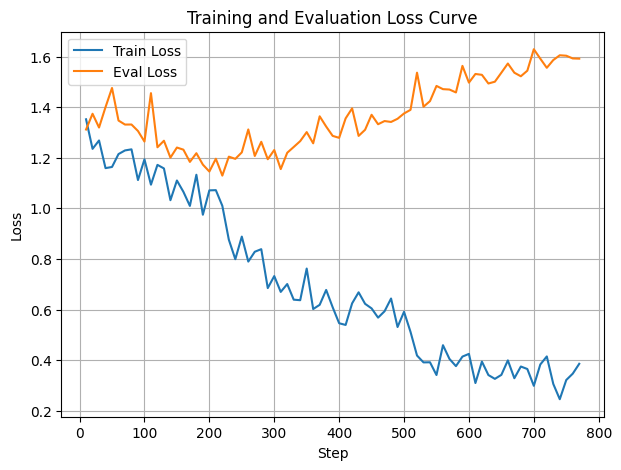

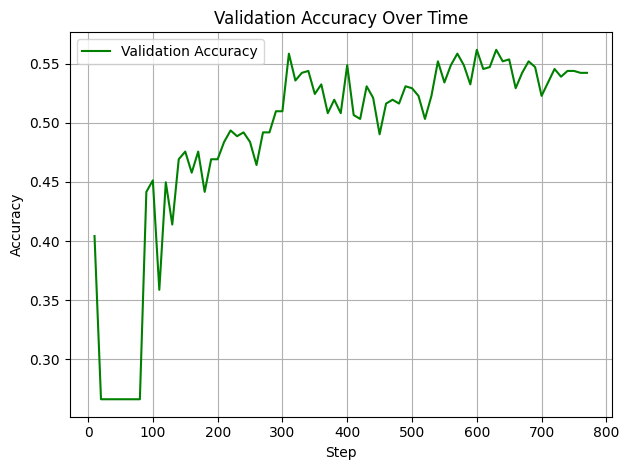

In [ ]:
# 2.2.2-C Learning Curves ------------------------
# use this section only if using the stepwise eval training argumetns

import matplotlib.pyplot as plt

logs = trainer_pairwise.state.log_history

# Plot Loss curves
plt.figure(figsize=(7, 5))

#plt.subplot(1, 2, 1)
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]
train_steps = [log["step"] for log in logs if "loss" in log]

plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss Curve")
plt.grid(True)
plt.show()

# Plot accuracy curve
eval_accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
accuracy_steps = [log["step"] for log in logs if "eval_accuracy" in log]

#plt.subplot(1, 2, 2)
plt.plot(accuracy_steps, eval_accuracy, label="Validation Accuracy", color="green")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 2.2.2-D Inferencing ------------------------

# Define checkpoint, load tokenizer, load checkpoint

#checkpoint = os.path.join(root_path, "model/fine_tuned_robertaBASE_pairwise_arch2/checkpoint-774")
checkpoint = "model/fine_tuned_robertaBASE/checkpoint-774"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # use original tokenizer for base model

#### Preprocess ####
dataset = load_dataset("json", data_files={
    "train": "processed/train_cls_ver2.jsonl",
    "dev": "processed/dev_cls_ver2.jsonl"
})

dev_data = dataset["dev"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()

#### Tokenization ####
def tokenize(example):
    return tokenizer(example["input"], truncation=True)

tokenized_dev = dev_data.map(tokenize, batched=True)

#### Prediction ####
outputs = trainer_pairwise.predict(tokenized_dev)
preds = outputs.predictions.argmax(axis=-1)

## Aggregate by claim_id
import numpy as np
from collections import defaultdict, Counter

# group prediction results by claim_id
claim_to_preds = defaultdict(list)
for pred, claim_id in zip(preds, tokenized_dev["claim_id"]):
    claim_to_preds[claim_id].append(pred)

# Majority vote among all 20 predictions for a claim
majority_preds = {
    cid: Counter(votes).most_common(1)[0][0]
    for cid, votes in claim_to_preds.items()
}

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

#### 2.2.2.1 Evaluation and Error Analysis (on Dev Set)

0.5324675324675324


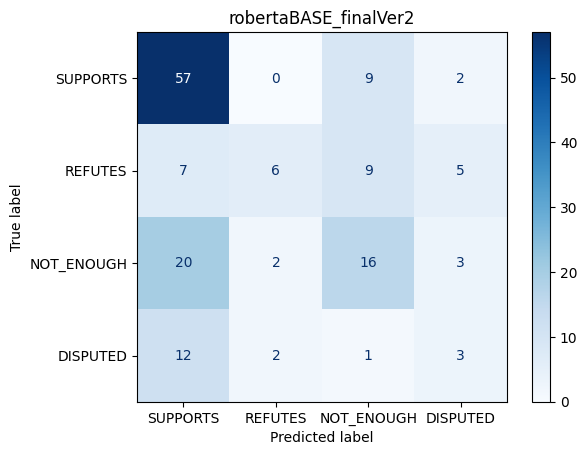

In [ ]:
#### Evaluation & Error Analysis ####
from sklearn.metrics import accuracy_score

y_true = dev_data["labels"][::4]
y_pred = [int(majority_preds[cid]) for cid in majority_preds.keys()]

print(accuracy_score(y_true, y_pred))

## Plot out the Confusion Matrix ##

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optional: class names (for axis labels)
class_names = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH', 'DISPUTED']  # Customize as needed

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("robertaBASE_final")
plt.show()

In [ ]:
# 2.2.2-F Prepare Output Json ------------------------
import json

# with open(os.path.join(root_path, "processed_ic/dev_cls_ver2.jsonl"), "r") as f:
#     json_list = [json.loads(line) for line in f]

with open("processed/dev_cls_ver2.jsonl", "r") as f:
    json_list = [json.loads(line) for line in f]

# Create dict indexed by claim_id
dev_processed_dict = {item["claim_id"]: item for item in json_list}

## Write predictions into json
# PRED_PATH = os.path.join(root_path, "prediction/dev-claims-predictions.json")
# os.makedirs(os.path.dirname(PRED_PATH), exist_ok=True)

PRED_PATH = "prediction/dev-claims-predictions.json"
os.makedirs(os.path.dirname(PRED_PATH), exist_ok=True)

# create json object
pred_json = {}
for cid, pred in majority_preds.items():
    # get evidence_id list
    evidence_list = []
    for ev in dev_processed_dict[cid]["evidences"]:
        evidence_list.append(ev["evidence_id"])

    pred_json[cid] = {"claim_label": id2lbl[pred],
                      "evidences": evidence_list}

with open(PRED_PATH, "w") as fout:
    json.dump(pred_json, fout)

print("✓ wrote prediction/dev-claims-predictions.json")

✓ wrote prediction/dev-claims-predictions.json


In [ ]:
# 2.2.2‑H  ·  Evaluate harmonic mean of evidence F + accuracy ------------------------
# !python /content/COMP90042_2025/eval.py \
#         --predictions /content/drive/MyDrive/prediction/dev-claims-predictions.json \
#         --groundtruth /content/COMP90042_2025/data/dev-claims.json

!python /content/COMP90042_2025/eval.py \
        --predictions /content/prediction/dev-claims-predictions.json \
        --groundtruth /content/COMP90042_2025/data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.17743764172335602
Claim Classification Accuracy (A) = 0.5324675324675324
Harmonic Mean of F and A          = 0.266175784288307


In [ ]:
# Evaluate the provided baseline predictions
!python /content/COMP90042_2025/eval.py \
        --predictions /content/COMP90042_2025/data/dev-claims-baseline.json \
        --groundtruth /content/COMP90042_2025/data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.3377705627705628
Claim Classification Accuracy (A) = 0.35064935064935066
Harmonic Mean of F and A          = 0.3440894901357093


### 2.2.3 Balancing Training Dataset

In [ ]:
# 2.1.3-A (option 1) Downsampling Training Dataset ------------------------

# from collections import defaultdict

# # Label distribution:
# #                  train  dev
# # DISPUTED           124   18
# # REFUTES            199   27
# # SUPPORTS           519   68
# # NOT_ENOUGH_INFO    386   41

# # id → label
# id2lbl = {0:"SUPPORTS",1:"REFUTES",2:"NOT_ENOUGH_INFO",3:"DISPUTED"}
# # label → id
# lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# # Downsample all label-size to the least training label-size

# target_size = 124  # DISPUTED

# claims_train_balanced = {}
# label_counter = defaultdict(int)

# label_counter["DISPUTED"] = 0
# label_counter["REFUTES"] = 0
# label_counter["SUPPORTS"] = 0
# label_counter["NOT_ENOUGH_INFO"] = 0


# for cid, claim in claims_train.items():
#     if label_counter[claim["claim_label"]] < target_size:
#         claims_train_balanced[cid] = claim
#         label_counter[claim["claim_label"]] += 1

# SUPPORTS_tags = len([claim for claim in claims_train_balanced.values() if claim['claim_label']=="SUPPORTS"])
# REFUTES_tags = len([claim for claim in claims_train_balanced.values() if claim['claim_label']=="REFUTES"])
# NOT_ENOUGH_INFO_tags = len([claim for claim in claims_train_balanced.values() if claim['claim_label']=="NOT_ENOUGH_INFO"])
# DISPUTED_tags = len([claim for claim in claims_train_balanced.values() if claim['claim_label']=="DISPUTED"])

# print(f"length of balanced dataset is: {len(claims_train_balanced)}.\n")
# print(f"SUPPORTS tags: {SUPPORTS_tags}.")
# print(f"REFUTES tags: {REFUTES_tags}.")
# print(f"NOT_ENOUGH_INFO tags: {NOT_ENOUGH_INFO_tags}.")
# print(f"DISPUTED tags: {DISPUTED_tags}.")

# # write data to json file

# with open(os.path.join(root_path, "processed/train_cls_balanced.jsonl"), "w") as fout:
#     for cid, obj in claims_train_balanced.items():
#         claim  = obj["claim_text"]
#         labels  = lbl2id[obj["claim_label"]]
#         evidences    = obj["evidences"]  # ground truth evidences

#         evidence_list = []

#         for eid in evidences:
#             evidence_list.append({
#                 "evidence_id": eid,
#                 "evidence_text": evidence_corpus[eid]
#             })

#         fout.write(json.dumps({"claim_id":cid,
#                  "claim": claim,
#                  "labels": labels,
#                  "evidences": evidence_list
#         }) + "\n")

# print(" Wrote to processed/train_cls_balanced.jsonl")

In [ ]:
# 2.1.3-A (option 2) Upsampling Training Dataset ------------------------

# from collections import defaultdict
# import random
# import os
# import json

# # Make sure randomness is reproducible
# random.seed(42)

# # id → label
# id2lbl = {0:"SUPPORTS",1:"REFUTES",2:"NOT_ENOUGH_INFO",3:"DISPUTED"}
# # label → id
# lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# # Group claims by label
# label_to_claims = defaultdict(list)
# for cid, claim in claims_train.items():
#     label_to_claims[claim["claim_label"]].append((cid, claim))

# # Find max label size (i.e., target size for upsampling)
# target_size = max(len(claims) for claims in label_to_claims.values())

# # Upsample each label group to the target size
# claims_train_balanced = {}
# for label, claim_list in label_to_claims.items():
#     upsampled = random.choices(claim_list, k=target_size) if len(claim_list) < target_size else claim_list
#     for cid, claim in upsampled:
#         new_id = cid
#         # Avoid ID collisions in case of duplicates
#         while new_id in claims_train_balanced:
#             new_id = cid + "_dup" + str(random.randint(0, 9999))
#         claims_train_balanced[new_id] = claim

# # Check distribution
# counter = defaultdict(int)
# for claim in claims_train_balanced.values():
#     counter[claim["claim_label"]] += 1

# print(f"length of balanced dataset is: {len(claims_train_balanced)}.\n")
# for label in lbl2id:
#     print(f"{label} tags: {counter[label]}.")

# # Write to JSONL
# with open(os.path.join(root_path, "processed/train_cls_balanced.jsonl"), "w") as fout:
#     for cid, obj in claims_train_balanced.items():
#         claim = obj["claim_text"]
#         labels = lbl2id[obj["claim_label"]]
#         evidences = obj["evidences"]

#         evidence_list = [{
#             "evidence_id": eid,
#             "evidence_text": evidence_corpus[eid]
#         } for eid in evidences]

#         fout.write(json.dumps({
#             "claim_id": cid,
#             "claim": claim,
#             "labels": labels,
#             "evidences": evidence_list
#         }) + "\n")

# print("Wrote to processed/train_cls_balanced.jsonl")


In [ ]:
# 2.1.3-B Fine-tuning on Balanced Dataset ------------------------
# checkpoint = "FacebookAI/roberta-base"  # change model here for different model fine tuning
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# dataset = load_dataset("json", data_files={
#     'train': os.path.join(root_path, 'processed/train_cls_balanced.jsonl'),   # temporary, for testing only
#     'dev': os.path.join(root_path, 'processed/dev_cls.jsonl')})

# # dataset = load_dataset("json", data_files={
# #     "train": "processed/train_cls_balanced.jsonl",
# #     "dev": "processed/dev_cls.jsonl"
# # })

# def preprocess_pairwise(example):

#     all_inputs = []
#     all_labels = []
#     all_claim_ids = []
#     all_claims = [] # store all claims

#     for claim_id, claim_text, label, evidences in zip(example["claim_id"], example["claim"], example["labels"], example["evidences"]):
#         for evidence in evidences:
#             evidence_txt = evidence["evidence_text"]
#             input = claim_text + " [SEP] " + evidence_txt
#             all_inputs.append(input)
#             all_labels.append(label)
#             all_claim_ids.append(claim_id)
#             all_claims.append(claim_text) # append claim for each evidence

#     return {
#         "input": all_inputs,
#         "labels": all_labels,
#         "claim_id": all_claim_ids,
#         "claim": all_claims # return all claims to maintain length
#     }

# train_data = dataset["train"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()  # flatten_indices to resolve 20 claim-evidence pair
# dev_data = dataset["dev"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()

# #### Tokenization ####
# def tokenize(example):
#     return tokenizer(example["input"], truncation=True)

# train_tokenized = train_data.map(tokenize, batched=True)
# dev_tokenized = dev_data.map(tokenize, batched=True)

# # DataCollator
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
## Training

# # Load checkpoint
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # find GPU
# print("Using device: ", device)

# model = AutoModelForSequenceClassification.from_pretrained(
#     checkpoint, num_labels=4, id2label=id2lbl, label2id=lbl2id
# ).to(device)

# # Define eval metrics
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)   # accuracy as metric
#     return {"accuracy": (predictions == labels).mean()}

In [ ]:
#### Use these lines for Learning Curves ####
# training_args_pairwise = TrainingArguments(
#     output_dir=os.path.join(root_path, "fine_tuned_robertaBASE_upsample-5epoch"),
#     num_train_epochs=3,
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     eval_strategy="steps",
#     eval_steps=20,            # Change this based on your dataset size
#     logging_steps=20,
#     save_steps=800,
#     save_total_limit=2,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",  # or "f1", etc.
#     report_to="wandb",         # Comment this line if don't want plot on wandb
#     run_name="robertaBASE_balanced"
#     # 🔽 Scheduler added below
#     # lr_scheduler_type="linear",       # or "cosine", "constant", etc.
#     # warmup_ratio=0.1                  # Warmup for 10% of training steps
# )


# # Prepare trainer
# trainer_pairwise = Trainer(
#     model=model,
#     args=training_args_pairwise,
#     train_dataset=train_tokenized,
#     eval_dataset=dev_tokenized,
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# # Run training
# trainer_pairwise.train()

In [ ]:
# 2.1.2-D Inferencing ------------------------

# Define checkpoint, load tokenizer, load checkpoint

# checkpoint = os.path.join(root_path, "fine_tuned_robertaBASE_upsample-5epoch/checkpoint-1272")
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # use original tokenizer for base model

# #### Preprocess ####
# dataset = load_dataset("json", data_files={
#     'train': os.path.join(root_path, 'processed/train_cls.jsonl'),   # temporary, for testing only
#     'dev': os.path.join(root_path, 'processed/dev_cls.jsonl')})
# dev_data = dataset["dev"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences', 'labels'])  #.flatten_indices()

# #### Tokenization ####
# def tokenize(example):
#     return tokenizer(example["input"], truncation=True)

# tokenized_dev = dev_data.map(tokenize, batched=True)

# #### Prediction ####
# outputs = trainer_pairwise.predict(tokenized_dev)
# preds = outputs.predictions.argmax(axis=-1)

# ## Aggregate by claim_id
# import numpy as np
# from collections import defaultdict, Counter

# # group prediction results by claim_id
# claim_to_preds = defaultdict(list)
# for pred, claim_id in zip(preds, tokenized_dev["claim_id"]):
#     claim_to_preds[claim_id].append(pred)

# # Majority vote among all 20 predictions for a claim
# majority_preds = {
#     cid: Counter(votes).most_common(1)[0][0]
#     for cid, votes in claim_to_preds.items()
# }

In [ ]:
#### Evaluation & Error Analysis ####
# from sklearn.metrics import accuracy_score

# y_true = dev_data["labels"][::20]
# y_pred = [int(majority_preds[cid]) for cid in majority_preds.keys()]

# print(accuracy_score(y_true, y_pred))

# ## Plot out the Confusion Matrix ##

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Optional: class names (for axis labels)
# class_names = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH', 'DISPUTED']  # Customize as needed

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot it
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap=plt.cm.Blues)
# plt.title("robertaBASE_balanced_upsample")
# plt.show()

In [ ]:
# 2.1.2-F Prepare Output Json ------------------------
# import json

# with open(os.path.join(root_path, "processed/dev_cls.jsonl"), "r") as f:
#     json_list = [json.loads(line) for line in f]

# # Create dict indexed by claim_id
# dev_processed_dict = {item["claim_id"]: item for item in json_list}

# ## Write predictions into json
# PRED_PATH = os.path.join(root_path, "prediction/dev-claims-predictions.json")
# os.makedirs(os.path.dirname(PRED_PATH), exist_ok=True)

# # create json object
# pred_json = {}
# for cid, pred in majority_preds.items():
#     # get evidence_id list
#     evidence_list = []
#     for ev in dev_processed_dict[cid]["evidences"]:
#         evidence_list.append(ev["evidence_id"])

#     pred_json[cid] = {"claim_label": id2lbl[pred],
#                       "evidences": evidence_list}

# with open(PRED_PATH, "w") as fout:
#     json.dump(pred_json, fout)

# print("✓ wrote prediction/dev-claims-predictions.json")

In [ ]:
# 2.2‑H  ·  Evaluate harmonic mean of evidence F + accuracy ------------------------
# !python /content/COMP90042_2025/eval.py \
#         --predictions /content/drive/MyDrive/prediction/dev-claims-predictions.json \
#         --groundtruth /content/COMP90042_2025/data/dev-claims.json

## 2.3 Modelling Claim Verification as Generation Task(Method B - In Context)

In [ ]:
# !pip uninstall -y datasets
# !pip install -U datasets

In [ ]:
# # 2.3‑A  ·  Install deps & import
# !pip -q install transformers accelerate sentencepiece --upgrade
# # !pip install -U datasets
# from pathlib import Path
# import json, random, torch
# import time
# from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# # 1-A · SETUP ----------------------------------------------------------

# !pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu datasets

# import json, re, os, gc, math, random, itertools, collections
# from pathlib import Path
# from tqdm.auto import tqdm
# import pandas as pd
# import json, numpy as np, torch, gc
# from rank_bm25 import BM25Okapi
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# from sentence_transformers import SentenceTransformer, CrossEncoder
# import faiss, numpy as np, torch
# import time
# import sys  # Import the sys module

# # Reproducibility
# SEED = 42
# random.seed(SEED); np.random.seed(SEED)

# import gdown

# # Create target folder
# !mkdir -p /content/COMP90042_2025/data

# # Download to correct location
# gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
#                output='/content/COMP90042_2025/data/evidence.json',
#                quiet=False)
# # 1-B : PATHS
# DATA_DIR = Path("/content/COMP90042_2025/data")
# TRAIN_PATH = DATA_DIR / "train-claims.json"
# DEV_PATH = DATA_DIR / "dev-claims.json"
# BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
# EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# # Check all paths exist
# assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
#     "Check that the dataset files are in DATA_DIR"

# # --- File Reader ---
# def read_json(path):
#     with open(path, encoding="utf-8") as f:
#         return json.load(f)

# # --- Load Data ---
# claims_train = read_json(TRAIN_PATH)
# claims_dev = read_json(DEV_PATH)
# claims_baseline = read_json(BASELINE_PATH)
# evidence_corpus = read_json(EVID_PATH)

# # --- Summary and Previews ---
# print("✔ Loaded Data Summary\n")

# # 1. Train Claims
# print("Train Claims:")
# print(f"  Total: {len(claims_train)}")
# sample_key = next(iter(claims_train))
# print(f"  Sample:\n{json.dumps(claims_train[sample_key], indent=4)}\n")

# # 2. Dev Claims
# print("Dev Claims:")
# print(f"  Total: {len(claims_dev)}")
# sample_key = next(iter(claims_dev))


In [ ]:
# # 2.3‑B  ·  Config
# EVAL_DIR   = Path("/content/COMP90042_2025")
# PROC_DIR   = Path("/content")

# TRAIN_CLS  = PROC_DIR / "processed/train_cls_ver1.jsonl"
# DEV_CLS    = PROC_DIR / "processed/dev_cls_ver1.jsonl"


# model_id   = "google/flan-t5-large"

# MAX_INPUT  = 512          # token budget for prompt + query
# NUM_DEMOS  = 2         # how many in‑context examples
# random.seed(41)

In [ ]:
# # 2.3-C  ·  LLM Loading and Inferencing Test (robust for seq2seq & causal LLMs)
# import torch
# from transformers import (
#     AutoConfig,
#     AutoTokenizer,
#     AutoModelForSeq2SeqLM,
#     AutoModelForCausalLM,
# )

# # 1) pick device
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"→ Using device: {DEVICE}")

# # 2) load config to determine model type
# config = AutoConfig.from_pretrained(model_id)
# is_encoder_decoder = getattr(config, "is_encoder_decoder", False)

# # 3) load & configure tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
# # many decoder-only models lack a pad token; use eos_token instead
# if tokenizer.pad_token_id is None:
#     tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
# tokenizer.truncation_side = "right"

# # 4) load appropriate model class
# ModelClass = AutoModelForSeq2SeqLM if is_encoder_decoder else AutoModelForCausalLM
# model = ModelClass.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
#     low_cpu_mem_usage=True,
# ).to(DEVICE).eval()

# # diagnostics
# print(" • model type       :", "seq2seq" if is_encoder_decoder else "causal")
# print(" • pad_token_id     :", tokenizer.pad_token_id)
# print(" • model device     :", next(model.parameters()).device)

# # 5) quick inference test
# prompt = (
#     "Given the claim and evidence, respond with one of: SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED.\n\n"
#     "Claim: The sun is hot.\n"
#     "Evidence: The sun emits thermal radiation.\n"
#     "Verdict:"
# )
# # tokenize *after* pad/truncation config
# inputs = tokenizer(
#     prompt,
#     return_tensors="pt",
#     truncation=True,
#     padding=True,
#     max_length=512,
# ).to(DEVICE)

# with torch.no_grad():
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=4,
#         pad_token_id=tokenizer.pad_token_id
#     )

# print("Prediction:", tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
# # 2.3‑D  ·  Load processed JSONL
# def read_jsonl(path):
#     with open(path) as f:
#         return [json.loads(line) for line in f]

# train_recs = read_jsonl(TRAIN_CLS)
# dev_recs   = read_jsonl(DEV_CLS)

# print(f"Loaded {len(train_recs)} train and {len(dev_recs)} dev examples")


In [ ]:
# # ===============================================================
# # 2.3‑E · Prompt builder   (label‑balanced demos + robust parsing)
# # ===============================================================
# label_map = {0:"SUPPORTS", 1:"REFUTES",
#              2:"NOT_ENOUGH_INFO", 3:"DISPUTED"}
# REV_MAP   = {v:k for k,v in label_map.items()}

# # ---------- build label‑indexed pools once ---------------------
# EVID_TRIM_DEMO = 50          # words kept per demo evidence
# pools = {l: [] for l in range(4)}
# for rec in train_recs:
#     pools[rec["label_id"]].append(rec)

# def sample_demos(k=4):
#     """Return k demos containing **at least one of each label**."""
#     base = [random.choice(pools[i]) for i in range(4)]   # 4 labels
#     if k > 4:
#         others = random.sample(train_recs, k-4)
#         base.extend(others)
#     random.shuffle(base)
#     demos = []
#     for d in base[:k]:
#         e_txt = " ".join(" ".join(d["evidences"]).split()[:EVID_TRIM_DEMO])
#         demos.append((d["claim"], e_txt, label_map[d["label_id"]]))
#     return demos

# def build_prompt(demos, claim, evid):
#     header = (
#         "You are a fact‑checking assistant.\n"
#         "Classify the CLAIM given the EVIDENCE as exactly one word:\n"
#         "SUPPORTS, REFUTES, NOT_ENOUGH_INFO, or DISPUTED.\n"
#         "###\n"
#     )
#     blocks = [f"Claim: {c}\nEvidence:\n{e}\nAnswer: {lbl}\n###"
#               for c,e,lbl in demos]
#     query  = f"Claim: {claim}\nEvidence:\n{evid}\nAnswer:"
#     return header + "\n\n".join(blocks) + "\n\n" + query

# # ---------- robust safe‑label ---------------------------------
# import re
# _PAT = {0:r"\bSUPPORTS?\b",
#         1:r"\bREFUTES?\b",
#         2:r"\bNOT[_ ]?ENOUGH[_ ]?INFO\b|\bNEI\b",
#         3:r"\bDISPUTED?\b"}
# REGEX = {i: re.compile(p, re.I) for i,p in _PAT.items()}

# def safe_label(text: str) -> int:
#     for idx,rx in REGEX.items():
#         if rx.search(text):
#             return idx
#     return 2   # default to NEI if ambiguous

In [ ]:
# # 2.3-F · Predict label (aggressively trimmed + sampled + sampled decode)
# def predict_label(claim, evidences_txt, *, return_raw=False, verbose=False):
#     # 1) sample demos
#     demos = random.sample(train_recs, min(NUM_DEMOS, len(train_recs)))
#     demo_tuples = [
#         (d["claim"], "\n".join(d["evidences"]), label_map[d["label_id"]])
#         for d in demos
#     ]

#     # 2) trim evidence more aggressively (≈80 words)
#     ev_trim = " ".join(evidences_txt.split()[:1000])

#     # 3) build prompt
#     prompt = build_prompt(demo_tuples, claim, ev_trim)

# # 4) tokenize (we already set tokenizer.truncation_side="right" above)
#     inputs = tokenizer(
#         prompt,
#         return_tensors="pt",
#         padding="longest",
#         truncation=True,
#         max_length=MAX_INPUT
#     ).to(DEVICE)
#     # 5) sampled decode so it actually writes something
#     with torch.no_grad():
#         out_ids = model.generate(
#            **inputs,
#           max_new_tokens=1,
#           do_sample=False,
#           pad_token_id=tokenizer.pad_token_id
#         )

#     raw = tokenizer.decode(out_ids[0], skip_special_tokens=True)
#     verdict = raw.split("Verdict:")[-1].strip().upper()
#     label_id = safe_label(verdict)

#     if verbose:
#         print("── FULL PROMPT ───────────────────────────────────────────")
#         print(prompt)
#         print("── TRIMMED EVIDENCE (~80 words) ──────────────────────────")
#         print(ev_trim)
#         print("── RAW MODEL OUTPUT ────────────────────────────────────")
#         print(raw)
#         print("── EXTRACTED VERDICT ──────────────────────────────────")
#         print(f"‘{verdict}’")
#         print("── MAPPED LABEL ───────────────────────────────────────")
#         print(label_map[label_id])

#     if return_raw:
#         return label_id, raw
#     return label_id

# # 2.3-F-1 · Debug helper (prints full prompt etc)
# def debug_dev_predictions(n=3):
#     examples = random.sample(dev_recs, n)
#     for i, rec in enumerate(examples, 1):
#         print(f"\n🔍 Example {i}/{n}")
#         # claim + evidence text
#         claim = rec["claim"]
#         if rec["evidences"] and rec["evidences"][0].startswith("evidence-"):
#             evidences_txt = "\n".join(evidence_corpus[eid] for eid in rec["evidences"])
#         else:
#             evidences_txt = "\n".join(rec["evidences"])

#         _label_id, _raw = predict_label(claim, evidences_txt,
#                                         return_raw=True,
#                                         verbose=True)

#         print(f"🔵 GROUND TRUTH: {label_map[rec['label_id']]}")
#         print("─" * 80)

# # run 5 examples
# debug_dev_predictions(n=5)

In [ ]:
# # 2.3‑G  ·  Run over dev, write evidence IDs + label (ICL only)

# from tqdm import tqdm
# import random, json, torch, time

# BATCH = 4
# pred_json = {}
# tqdm._instances.clear()

# def match_texts_to_ids(text_list):
#     matched_ids = []
#     for text in text_list:
#         found = False
#         for eid, passage in evidence_corpus.items():
#             if text.strip() == passage.strip():
#                 matched_ids.append(eid)
#                 found = True
#                 break
#         if not found:
#             print(f"⚠️ No match found for: {text[:80]}")
#     return matched_ids


# def claim_evidence_blocks(rec):
#     """
#     Combine claim + evidence text block from a dev record.
#     """
#     claim = rec["claim"]
#     first = rec["evidences"][0]
#     if isinstance(first, str) and first.startswith("evidence-"):
#         evtxt = "\n".join(evidence_corpus[eid] for eid in rec["evidences"])
#     else:
#         evtxt = "\n".join(rec["evidences"])
#     return claim, evtxt

# bar_fmt = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
# print(len(dev_recs), len(train_recs))  # confirm input sizes

# # Two clean progress bars
# p_total = tqdm(total=len(dev_recs), desc="📊 TOTAL    ", ncols=80, position=1, bar_format=bar_fmt)
# p_batch = tqdm(total=(len(dev_recs) + BATCH - 1) // BATCH, desc="📦 BATCHES  ", ncols=80, position=0, bar_format=bar_fmt)

# batched_prompts, batched_claims, batched_raw_records = [], [], []


# with open("/content/COMP90042_2025/data/dev-claims.json") as f:
#     dev_claims = json.load(f)

# # Build lookup: claim text → claim ID
# claim_text_to_id = {v["claim_text"]: k for k, v in dev_claims.items()}



# for idx, rec in enumerate(dev_recs, 1):
#     # 1) assemble claim + evidence text
#     claim, evtxt = claim_evidence_blocks(rec)
#     # 2) sample demos and build prompt
#     demos = random.sample(train_recs, min(NUM_DEMOS, len(train_recs)))
#     demo_tuples = [
#         (d["claim"], "\n".join(d["evidences"]), label_map[d["label_id"]])
#         for d in demos
#     ]
#     # 3) trim evidence to ~200 words to avoid prompt cutoff
#     ev_trim = " ".join(evtxt.split()[:200])
#     prompt = build_prompt(demo_tuples, claim, ev_trim)

#     batched_prompts.append(prompt)
#     batched_raw_records.append(rec)

#     # fire batch if ready or at end
#     if len(batched_prompts) == BATCH or idx == len(dev_recs):
#         print(f"\n🔥 Generating batch: {p_batch.n + 1}/{p_batch.total}")

#         # 4) tokenize with padding="longest"
#         inputs = tokenizer(
#             batched_prompts,
#             return_tensors="pt",
#             padding="longest",
#             truncation=True,
#             max_length=MAX_INPUT
#         ).to(DEVICE)

#         # 5) greedy decode
#         start = time.time()
#         with torch.no_grad():
#             outs = model.generate(
#                 **inputs,
#                 max_new_tokens=4,
#                 do_sample=False,
#                 temperature=0.0,
#                 pad_token_id=tokenizer.pad_token_id
#             )
#         print(f"✅ Batch done in {time.time() - start:.2f}s")

#         # 6) decode and record
#         for rec, out in zip(batched_raw_records, outs):
#             claim    = rec["claim"]
#             verdict  = tokenizer.decode(out, skip_special_tokens=True).split("Verdict:")[-1]
#             lbl_id   = safe_label(verdict)
#             claim_id = claim_text_to_id.get(claim)
#             if claim_id is None:
#                 print(f"⚠️ No claim ID match for: {claim[:80]}")
#                 continue

#             pred_json[claim_id] = {
#                 "claim_text":  claim,
#                 "claim_label": label_map[lbl_id],
#                 "evidences":   match_texts_to_ids(rec["evidences"])
#             }

#         # 7) advance progress bars
#         p_total.update(len(batched_prompts))
#         p_batch.update(1)

#         # 8) reset batch buffers
#         batched_prompts, batched_raw_records = [], []

# p_total.close()
# p_batch.close()

# with open("dev-claims-predictions.json", "w") as f:
#     json.dump(pred_json, f, indent=2)

# print("✓ Inference complete. Saved dev-claims-predictions.json")


In [ ]:
# # 2.3‑H  ·  Evaluate harmonic mean of evidence F + accuracy
# !python /content/COMP90042_2025/eval.py \
#         --predictions dev-claims-predictions.json \
#         --groundtruth /content/COMP90042_2025/data/dev-claims.json


Evidence Retrieval F-score (F)    = 0.19508864151721295
Claim Classification Accuracy (A) = 0.36363636363636365
Harmonic Mean of F and A          = 0.2539400368114107


In [ ]:
# # Evaluate the provided baseline predictions
# !python /content/COMP90042_2025/eval.py \
#         --predictions /content/COMP90042_2025/data/dev-claims-baseline.json \
#         --groundtruth /content/COMP90042_2025/data/dev-claims.json


Evidence Retrieval F-score (F)    = 0.3377705627705628
Claim Classification Accuracy (A) = 0.35064935064935066
Harmonic Mean of F and A          = 0.3440894901357093


### 2.3.1 Evaluation & Error Analysis (on Dev Set)

In [ ]:
# import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
# from pathlib import Path

# # ---------- Re‑load the evaluation artefacts (paths come from your notebook) ----------
# GT_PATH    = Path("/content/COMP90042_2025/data/dev-claims.json")
# BASE_PATH  = Path("/content/COMP90042_2025/data/dev-claims-baseline.json")
# ICL_PATH   = Path("/content/dev-claims-predictions.json")

# LABELS  = ["SUPPORTS","REFUTES","NOT_ENOUGH_INFO","DISPUTED"]
# label2id = {l:i for i,l in enumerate(LABELS)}

# def load_json(path):
#     with open(path) as f:
#         return json.load(f)

# gold_full = load_json(GT_PATH)
# gold_labels = {k:v["claim_label"] for k,v in gold_full.items()}
# base_pred  = load_json(BASE_PATH)
# icl_pred   = load_json(ICL_PATH)

# # Vectorise labels -------------------------------------------------------------
# y_true  = []
# y_base  = []
# y_icl   = []

# for cid, gold_lbl in gold_labels.items():
#     if cid in base_pred and cid in icl_pred:
#         y_true.append(label2id[gold_lbl])
#         y_base.append(label2id[base_pred[cid]["claim_label"]])
#         y_icl.append(label2id[icl_pred[cid]["claim_label"]])

# y_true  = np.array(y_true)
# y_base  = np.array(y_base)
# y_icl   = np.array(y_icl)


In [ ]:
# # ----------------------- paths & labels ------------------------
# GT  = "/content/COMP90042_2025/data/dev-claims.json"
# P_BASE = "/content/COMP90042_2025/data/dev-claims-baseline.json"
# P_ICL  = "/content/dev-claims-predictions.json"       # cap=200 run
# LABELS = ["SUPPORTS","REFUTES","NOT_ENOUGH_INFO","DISPUTED"]
# label2id = {l:i for i,l in enumerate(LABELS)}

# # ----------------------- load helpers --------------------------
# import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
# from sklearn.metrics import (classification_report, confusion_matrix,
#                              accuracy_score, f1_score)

# def load(path):                     # claim_id → full obj
#     with open(path) as f: return json.load(f)

# def to_vec(pred_map, gold_map):
#     y_g,y_p = [],[]
#     for cid,g in gold_map.items():
#         if cid in pred_map:
#             y_g.append(label2id[g["claim_label"]] if isinstance(g,dict) else label2id[g])
#             y_p.append(label2id[pred_map[cid]["claim_label"]])
#     return np.array(y_g), np.array(y_p)

# gold_full   = load(GT)
# gold_labels = {k:v["claim_label"] for k,v in gold_full.items()}
# base        = load(P_BASE)
# icl         = load(P_ICL)

# y_gold, y_base = to_vec(base, gold_labels)
# _,      y_icl  = to_vec(icl , gold_labels)


,System,Acc%,Macro‑F1%,F1-SUPPORTS%,F1-REFUTES%,F1-NOT_ENOUGH_INFO%,F1-DISPUTED%
0,Baseline,35.100000,32.500000,42.200000,34.900000,36.400000,16.700000
1,In‑Context,36.400000,32.000000,55.700000,28.000000,25.000000,19.400000


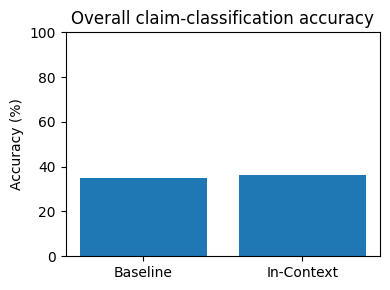

In [ ]:
# # 1 · SUMMARY TABLE & BAR PLOT
# def summarise(y_true,y_pred,name):
#     acc  = accuracy_score(y_true,y_pred)*100
#     f1m  = f1_score(y_true,y_pred,average="macro")*100
#     rep  = classification_report(y_true,y_pred,target_names=LABELS,output_dict=True)
#     row  = [name, acc, f1m] + [rep[l]["f1-score"]*100 for l in LABELS]
#     return row

# cols = ["System","Acc%","Macro‑F1%"] + [f"F1-{l}%" for l in LABELS]
# tbl  = pd.DataFrame([ summarise(y_gold,y_base,"Baseline"),
#                       summarise(y_gold,y_icl ,"In‑Context") ],
#                     columns=cols).round(1)
# display(tbl.style.set_caption("Table 1 – Quantitative comparison"))

# # overall accuracy bar
# plt.figure(figsize=(4,3))
# plt.bar(["Baseline","In‑Context"], tbl["Acc%"])
# plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
# plt.title("Overall claim‑classification accuracy")
# plt.tight_layout(); plt.show()


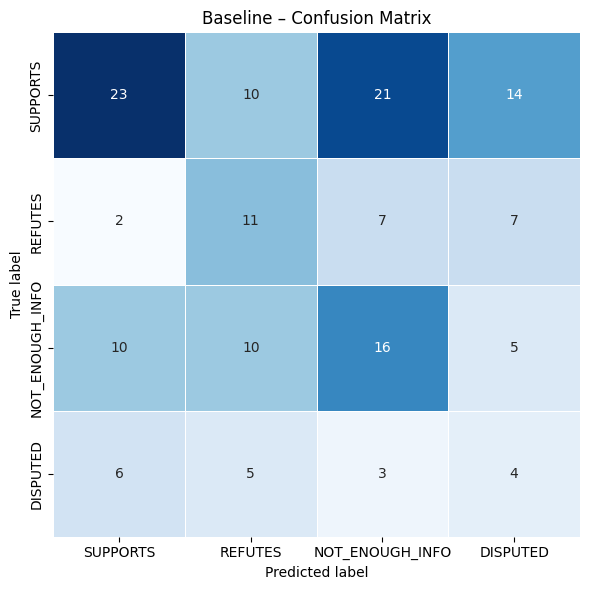

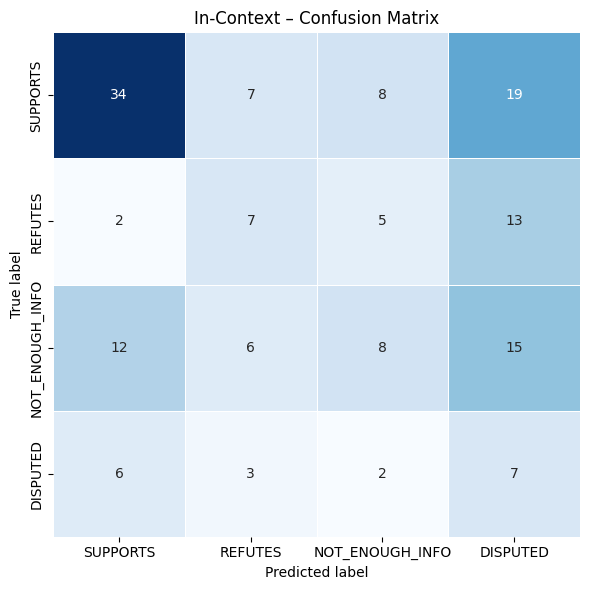

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# LABELS = ["SUPPORTS","REFUTES","NOT_ENOUGH_INFO","DISPUTED"]

# def plot_cm(y_t, y_p, title):
#     cm = confusion_matrix(y_t, y_p, labels=range(len(LABELS)))
#     fig, ax = plt.subplots(figsize=(6, 6))
#     sns.heatmap(cm,
#                 annot=True, fmt="d", cmap="Blues",
#                 xticklabels=LABELS, yticklabels=LABELS,
#                 ax=ax, cbar=False, linewidths=.5)
#     ax.set_xlabel("Predicted label")
#     ax.set_ylabel("True label")
#     ax.set_title(title)
#     fig.tight_layout()
#     return fig, cm

# fig1, cm_base = plot_cm(y_true, y_base,  "Baseline – Confusion Matrix")
# fig2, cm_icl  = plot_cm(y_true, y_icl,   "In‑Context – Confusion Matrix")
# plt.show()


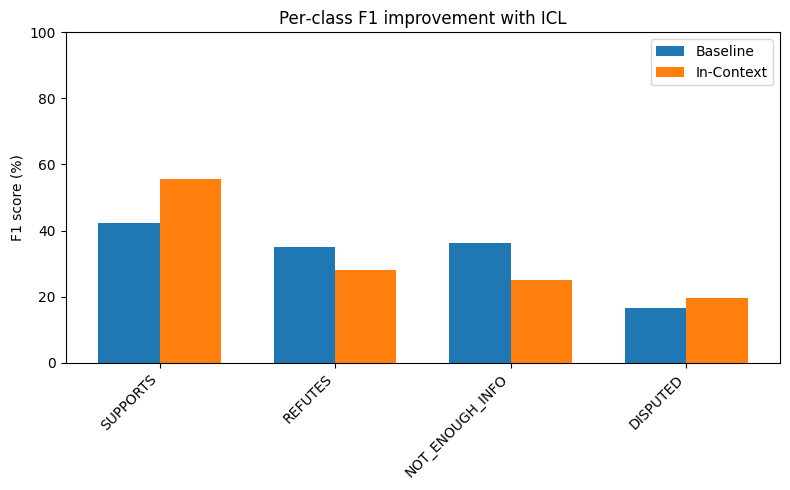

In [ ]:
# from sklearn.metrics import f1_score
# import numpy as np

# f1_b = f1_score(y_true, y_base, average=None)
# f1_i = f1_score(y_true, y_icl , average=None)

# x     = np.arange(len(LABELS))
# width = .35

# plt.figure(figsize=(8, 5))
# plt.bar(x-width/2, f1_b*100, width, label="Baseline")
# plt.bar(x+width/2, f1_i*100, width, label="In‑Context")
# plt.xticks(x, LABELS, rotation=45, ha="right")
# plt.ylabel("F1 score (%)")
# plt.ylim(0, 100)
# plt.title("Per‑class F1 improvement with ICL")
# plt.legend()
# plt.tight_layout()
# plt.show()


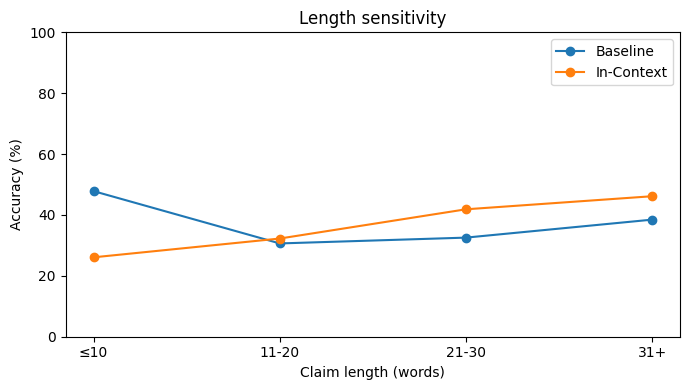

In [ ]:
# def bucket(wc):
#     if wc <= 10:  return "≤10"
#     if wc <= 20:  return "11‑20"
#     if wc <= 30:  return "21‑30"
#     return "31+"

# buckets = {b:{"n":0,"b_corr":0,"i_corr":0}
#            for b in ["≤10","11‑20","21‑30","31+"]}

# for cid in gold_full:
#     if cid not in base_pred or cid not in icl_pred: continue
#     wc = len(gold_full[cid]["claim_text"].split())
#     b  = bucket(wc)
#     buckets[b]["n"]      += 1
#     if base_pred[cid]["claim_label"] == gold_full[cid]["claim_label"]:
#         buckets[b]["b_corr"] += 1
#     if icl_pred[cid]["claim_label"] == gold_full[cid]["claim_label"]:
#         buckets[b]["i_corr"] += 1

# names   = list(buckets.keys())
# acc_b   = [buckets[b]["b_corr"]/buckets[b]["n"]*100 for b in names]
# acc_i   = [buckets[b]["i_corr"]/buckets[b]["n"]*100 for b in names]

# plt.figure(figsize=(7,4))
# plt.plot(names, acc_b, marker="o", label="Baseline")
# plt.plot(names, acc_i, marker="o", label="In‑Context")
# plt.xlabel("Claim length (words)")
# plt.ylabel("Accuracy (%)")
# plt.ylim(0, 100)
# plt.title("Length sensitivity")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# import pandas as pd
# from sklearn.metrics import (
#     accuracy_score, balanced_accuracy_score,
#     matthews_corrcoef, cohen_kappa_score, f1_score
# )

# def diag(y_t, y_p):
#     return {
#         "Accuracy":              accuracy_score(y_t,y_p),
#         "Balanced Acc":          balanced_accuracy_score(y_t,y_p),
#         "Macro F1":              f1_score(y_t,y_p,average="macro"),
#         "Matthews Corr":         matthews_corrcoef(y_t,y_p),
#         "Cohen Kappa":           cohen_kappa_score(y_t,y_p)
#     }

# tbl = pd.DataFrame(
#         [diag(y_true,y_base), diag(y_true,y_icl)],
#         index=["Baseline","In‑Context"]
#       ).round(3)*100

# display(tbl.style.set_caption("Table 2 – Extended diagnostic metrics"))


,Accuracy,Balanced Acc,Macro F1,Matthews Corr,Cohen Kappa
Baseline,35.100000,34.000000,32.500000,12.300000,11.900000
In‑Context,36.400000,33.600000,32.000000,14.600000,13.800000


In [ ]:
# rows = []
# for cid in gold_full:
#     g = gold_full[cid]["claim_label"]
#     if icl_pred[cid]["claim_label"] != g:
#         rows.append({
#             "claim_id":  cid,
#             "Gold":      g,
#             "ICL_pred":  icl_pred[cid]["claim_label"],
#             "Baseline":  base_pred[cid]["claim_label"],
#             "Claim":     gold_full[cid]["claim_text"][:120] + ("…" if len(gold_full[cid]["claim_text"])>120 else ""),
#             "Evidence":  gold_full[cid]["evidences"][0][:120] + "…"
#         })
#     if len(rows) == 25: break   # cap for readability

# pd.set_option("display.max_colwidth", None)
# err_df = pd.DataFrame(rows)
# display(err_df.style.set_caption("Table 3 – Sample mis‑classifications (ICL)"))


,claim_id,Gold,ICL_pred,Baseline,Claim,Evidence
0,claim-871,NOT_ENOUGH_INFO,DISPUTED,REFUTES,"“As it happens, Zika may also be a good model of the second worrying effect — disease mutation.",evidence-422399…
1,claim-1607,NOT_ENOUGH_INFO,DISPUTED,NOT_ENOUGH_INFO,CO2 limits won't cool the planet.,evidence-913997…
2,claim-761,NOT_ENOUGH_INFO,DISPUTED,SUPPORTS,[Riebesell] is a world authority on the topic and has typically communicated cautiously about the effects of acidificati…,evidence-1129386…
3,claim-1718,SUPPORTS,DISPUTED,SUPPORTS,The actual data show high northern latitudes are warmer today than in 1940.,evidence-857561…
4,claim-1786,REFUTES,DISPUTED,REFUTES,CFCs contribute to global waerming at a small level.,evidence-845527…
5,claim-2796,SUPPORTS,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,"Had he used the currently accepted value of approximately 3°C warming for a doubling of atmospheric CO2, Hansen would ha…",evidence-210167…
6,claim-2580,DISPUTED,REFUTES,DISPUTED,Volcanoes emit around 0.3 billion tonnes of CO2 per year.,evidence-15399…
7,claim-161,SUPPORTS,DISPUTED,DISPUTED,"Extreme melting and changes to the climate like this has released pressure on to the continent, allowing the ground to r…",evidence-702708…
8,claim-1256,DISPUTED,REFUTES,DISPUTED,"‘Next year or the year after, the Arctic will be free of ice’",evidence-731434…
9,claim-506,NOT_ENOUGH_INFO,DISPUTED,DISPUTED,More than 100 climate models over the past 30 years did not predict what actually happened because it was assumed carbon…,evidence-1199931…


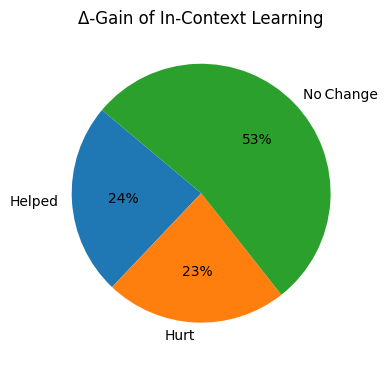

In [ ]:
# delta = {"Helped":0,"Hurt":0,"No Change":0}
# for cid in gold_full:
#     g = gold_full[cid]["claim_label"]
#     b_ok = (base_pred[cid]["claim_label"] == g)
#     i_ok = (icl_pred[cid]["claim_label"] == g)
#     if  b_ok and not i_ok:    delta["Hurt"]   += 1
#     elif not b_ok and i_ok:   delta["Helped"] += 1
#     else:                     delta["No Change"] += 1

# plt.figure(figsize=(4,4))
# plt.pie(delta.values(), labels=delta.keys(), autopct="%1.0f%%", startangle=140)
# plt.title("Δ‑Gain of In‑Context Learning")
# plt.tight_layout(); plt.show()


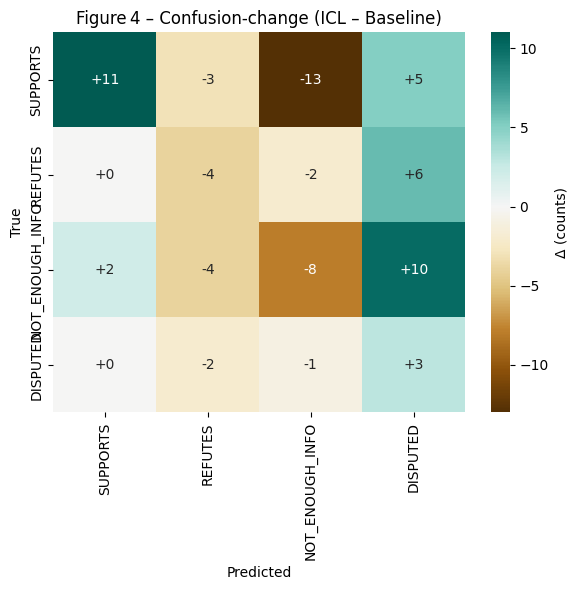

In [ ]:
# # Δ = (counts_ICL – counts_Baseline)
# import seaborn as sns, numpy as np
# delta_cm = cm_icl - cm_base      # uses cm_* from §1
# fmt = lambda v: f"{v:+d}"

# fig, ax = plt.subplots(figsize=(6,6))
# sns.heatmap(delta_cm,
#             annot=np.vectorize(fmt)(delta_cm),
#             fmt="", cmap="BrBG", center=0,
#             xticklabels=LABELS, yticklabels=LABELS,
#             ax=ax, cbar_kws={"label":"Δ (counts)"})
# ax.set_title("Figure 4 – Confusion‑change (ICL – Baseline)")
# ax.set_xlabel("Predicted"); ax.set_ylabel("True")
# fig.tight_layout(); plt.show()


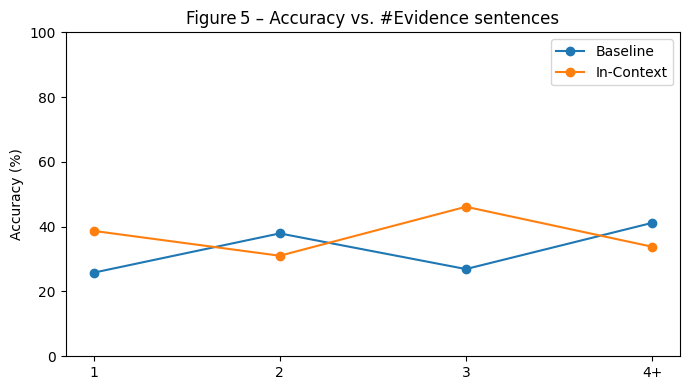

In [ ]:
# # Evidence‑Count Sensitivity
# buckets = {k:{"n":0,"base":0,"icl":0} for k in [1,2,3,"4+"]}

# for cid, g in gold_full.items():
#     n_ev = len(g["evidences"])
#     k    = n_ev if n_ev<4 else "4+"
#     buckets[k]["n"] += 1
#     if base_pred[cid]["claim_label"] == g["claim_label"]: buckets[k]["base"] += 1
#     if icl_pred[cid]["claim_label"]  == g["claim_label"]: buckets[k]["icl"]  += 1

# x        = list(buckets.keys())
# acc_base = [buckets[k]["base"]/buckets[k]["n"]*100 for k in x]
# acc_icl  = [buckets[k]["icl"] /buckets[k]["n"]*100 for k in x]

# plt.figure(figsize=(7,4))
# plt.plot(x, acc_base, marker="o", label="Baseline")
# plt.plot(x, acc_icl , marker="o", label="In‑Context")
# plt.ylabel("Accuracy (%)")
# plt.title("Figure 5 – Accuracy vs. #Evidence sentences")
# plt.ylim(0,100); plt.legend(); plt.tight_layout(); plt.show()


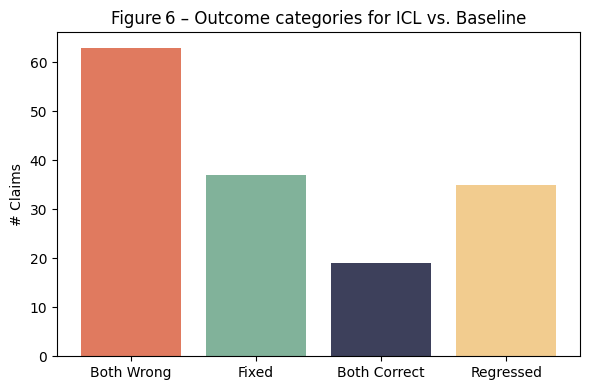

In [ ]:
# # Who’s Correct? Stacked Outcome Bars
# labels = ["Both Wrong","Fixed","Both Correct","Regressed"]
# counts = [0,0,0,0]

# for cid in gold_full:
#     g  = gold_full[cid]["claim_label"]
#     ok_b = base_pred[cid]["claim_label"] == g
#     ok_i = icl_pred[cid]["claim_label"]  == g
#     if  ok_b and  ok_i: counts[2]+=1
#     elif not ok_b and ok_i: counts[1]+=1  # Fixed
#     elif not ok_b and not ok_i: counts[0]+=1
#     else: counts[3]+=1                    # Regressed

# plt.figure(figsize=(6,4))
# plt.bar(labels, counts, color=["#e07a5f","#81b29a","#3d405b","#f2cc8f"])
# plt.ylabel("# Claims")
# plt.title("Figure 6 – Outcome categories for ICL vs. Baseline")
# plt.tight_layout(); plt.show()


### 2.3.2 Memory Clean up

In [ ]:
# !cat /proc/meminfo | grep Mem


In [ ]:
# import gc
# import torch

# gc.collect()                # clear Python memory
# torch.cuda.empty_cache()    # clear GPU memory (if any)

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

#### 3.1 Processing and Retrieval


In [ ]:
def free_memory():
    import gc, torch, sys
    from IPython import get_ipython

    # --- Step 1: Delete large global variables ---
    for name in [
        "tokenised_passages", "eid2idx", "idx2eid", "bm25",
        "emb", "dense_idx", "short_ids", "eid2dense",
        "sbert", "bm25_retriever", "dense_retriever", "dense_reranker"
    ]:
        if name in globals():
            globals()[name] = None
            del globals()[name]

    # --- Step 2: Garbage collect CPU memory ---
    gc.collect()

    # --- Step 3: Clear GPU cache ---
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    # --- Step 4: Delete modules from sys.modules (if dynamically imported) ---
    for module in ["faiss", "datasets"]:
        if module in sys.modules:
            del sys.modules[module]

    # --- Step 5: Clear interactive shell variables ---
    ipython = get_ipython()
    if ipython:
        ipython.magic("reset -f")

    # --- Final garbage collection ---
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [ ]:
# free_memory()

In [ ]:
######------ Re-build the Environment ------#####

# 1-A · SETUP ----------------------------------------------------------

!pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu
!pip install -U datasets

import json, re, os, gc, math, random, itertools, collections
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import json, numpy as np, torch, gc
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss, numpy as np, torch
import time
import sys  # Import the sys module

import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import gdown

# Create target folder
!mkdir -p /content/COMP90042_2025/data

# Download to correct location
gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
               output='/content/COMP90042_2025/data/evidence.json',
               quiet=False)



# 1-B : PATHS
DATA_DIR = Path("/content/COMP90042_2025/data")
TRAIN_PATH = DATA_DIR / "train-claims.json"
DEV_PATH = DATA_DIR / "dev-claims.json"
BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# Check all paths exist
assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
    "Check that the dataset files are in DATA_DIR"

# --- File Reader ---
def read_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

# --- Load Data ---
claims_train = read_json(TRAIN_PATH)
claims_dev = read_json(DEV_PATH)
claims_baseline = read_json(BASELINE_PATH)
evidence_corpus = read_json(EVID_PATH)

Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=cc211a2a-681e-4070-a5a2-26b0ad805aa5
To: /content/COMP90042_2025/data/evidence.json
100%|██████████| 174M/174M [00:01<00:00, 155MB/s]


In [ ]:
#######------------- Rebuild the Evidence Retriever ----------------########

# ===============================================================
# 2.1.2-E ·  LIGHT  IN-CONTEXT  RERANKER  (NEW)
# ===============================================================

USE_LLM        = False  ## set this to true in order to activate SBERT semantic search
LLM_MODEL      = "google/flan-t5-base"
LOAD_8BIT      = False
LLM_DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

FEW_SHOT_K     = 6
OUTPUT_TOP_K   = 4

EVID_MAX_TOK   = 60

import random, torch, gc
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig

# 🔧 (1) SEMANTIC-NEAREST SHOTS: enable if you want structure-aware demos
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer("all-MiniLM-L6-v2")  # only if using semantic demos

# ---------------------------------------------------------------
# 1.  STATIC FEW-SHOT BANK  (≈ 400 balanced examples)
# ---------------------------------------------------------------
random.seed(42)
POS_BANK, NEG_BANK = [], []
for obj in random.sample(list(claims_train.values()), 200):
    c      = obj["claim_text"]
    gold   = set(obj["evidences"])
    gold_e = [evidence_corpus[eid] for eid in gold]
    if gold_e:
        POS_BANK.append((c, random.choice(gold_e), "yes"))
    rand_eid, rand_txt = random.choice(list(evidence_corpus.items()))
    if rand_eid not in gold:
        NEG_BANK.append((c, rand_txt, "no"))

print(f"★ Few-shot bank: {len(POS_BANK)} pos / {len(NEG_BANK)} neg")

# ------ (1a) random + balanced demos (your original) -------------
def sample_few_shots(k=6):
    k2 = k // 2
    return random.sample(POS_BANK, k2) + random.sample(NEG_BANK, k - k2)

# ------ (1b) semantic-nearest demos (requires SBERT) -------------
def sample_few_shots_semantic(claim, k=6):
    # Encode demos
    demos = POS_BANK + NEG_BANK
    texts = [e for (_,e,_) in demos]
    embs  = sbert.encode(texts, normalize_embeddings=True)
    q_emb = sbert.encode([claim], normalize_embeddings=True)[0]
    sims  = (embs @ q_emb).tolist()
    # pick top-K while ensuring label balance
    idxs = sorted(range(len(sims)), key=lambda i: -sims[i])
    out, seen = [], set()
    for i in idxs:
        c,e,l = demos[i]
        if l not in seen:
            out.append((c,e,l)); seen.add(l)
        if len(out)==4: break
    # fill remaining
    while len(out)<k:
        out.append(random.choice(demos))
    random.shuffle(out)
    return out

# ---------------------------------------------------------------
# 2.  AUTO BATCH SIZE  (fits whatever GPU we get)
# ---------------------------------------------------------------
def auto_bsz(model_name, seq_len=256, vram=12):
    per = 0.004 * (seq_len / 256)
    return min(64, max(4, int(vram // per)))

BATCH_SIZE_LLM = auto_bsz(LLM_MODEL)
print("★ Batch size:", BATCH_SIZE_LLM)

# ---------------------------------------------------------------
# FULL InContextReranker   (patched _score + rerank intact)
# ---------------------------------------------------------------
class InContextReranker:
    # 🔧 (7) chain-of-thought prefix option: ask for reasoning then yes/no
    PREFIX = (
        "You are a fact-checker.\n"
        "First, in one sentence, explain whether this EVIDENCE makes the CLAIM more likely true or false.\n"
        "Then answer exactly 'yes' or 'no'.\n###\n"
    )

    def __init__(self):
        self.tok = AutoTokenizer.from_pretrained(LLM_MODEL)
        if LOAD_8BIT:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,     # enable 8-bit quantization
                llm_int8_threshold=6.0 # optional: tweak threshold
            )
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                LLM_MODEL,
                quantization_config=bnb_config,
                device_map="auto",
                trust_remote_code=True   # if the model needs it
            )
        else:
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                LLM_MODEL
            ).to(LLM_DEVICE)

        self.model.eval()
        self.yes_id = self.tok(" yes", add_special_tokens=False).input_ids[0]
        self.no_id  = self.tok(" no",  add_special_tokens=False).input_ids[0]

    # ---------- prompt builder ----------------------------------
    def _prompt(self, claim, evidence, shots):
        # 🔧 (3) dynamic head+tail trunc: keep first/last half of tokens
        tokens = evidence.split()
        if len(tokens)>EVID_MAX_TOK:
            half = EVID_MAX_TOK//2
            ev_short = " ".join(tokens[:half] + tokens[-half:])
        else:
            ev_short = " ".join(tokens)

        s_txt = "\n".join(f"CLAIM: {c}\nEVIDENCE: {e}\nANSWER: {l}"
                          for c,e,l in shots)
        return f"{self.PREFIX}{s_txt}\nCLAIM: {claim}\nEVIDENCE: {ev_short}\nANSWER:"

    # ---------- patched vectorised scorer -----------------------
    @torch.no_grad()
    def _score(self, prompts):
        enc = self.tok(prompts,
                       return_tensors="pt",
                       padding=True,
                       truncation=True,
                       # 🔧 (6) allow more context: up max_length to 320
                       max_length=320).to(LLM_DEVICE)

        bsz      = enc.input_ids.size(0)
        start_id = self.model.config.decoder_start_token_id
        dec_ids  = torch.full((bsz, 1),
                              start_id,
                              dtype=torch.long,
                              device=LLM_DEVICE)

        logits = self.model(**enc,
                            decoder_input_ids=dec_ids).logits  # (B,1,V)
        last   = logits.squeeze(1)
        logp   = F.log_softmax(last, dim=-1)

        # 🔧 (5) combine raw yes‐prob + margin:
        α, β = 1.0, 0.5
        yes_p = logp[:, self.yes_id]
        no_p  = logp[:, self.no_id]
        margin = yes_p - no_p
        combined = α*yes_p + β*margin
        return combined.cpu().tolist()

    # ---------- public API --------------------------------------
    def rerank(self, claim, cand_eids, k=OUTPUT_TOP_K):
        # 🔧 choose semantic or random demos via a flag:
        if USE_LLM and False:
            shots = sample_few_shots_semantic(claim, FEW_SHOT_K)
        else:
            shots = sample_few_shots(FEW_SHOT_K)

        scored = []
        for i in range(0, len(cand_eids), BATCH_SIZE_LLM):
            sub     = cand_eids[i:i+BATCH_SIZE_LLM]
            prompts = [self._prompt(claim, evidence_corpus[eid], shots)
                       for eid in sub]
            scored.extend(zip(sub, self._score(prompts)))

        # 🔧 sort by **highest** combined score instead of lowest margin
        return [eid for eid,_ in sorted(scored, key=lambda x: -x[1])[:k]]

# ---------------------------------------------------------------
# (re)-create dispatcher so rerank_llm points to the fresh object
# ---------------------------------------------------------------
if USE_LLM:
    llm_reranker = InContextReranker()
    def rerank_llm(claim, cand_ids, k=OUTPUT_TOP_K):
        return llm_reranker.rerank(claim, cand_ids, k)
else:
    rerank_llm = lambda claim, cand_ids, k=OUTPUT_TOP_K: cand_ids[:k]

print("✓ InContextReranker re-loaded with rerank()")


# 1.2-G · BM25 Retriever ----------------------------------------------------

class BM25Retriever:
    def __init__(self, corpus: dict, tokenizer):
        """
        corpus: dict of {eid: text}
        tokenizer: function to tokenize text
        """
        self.tokenizer = tokenizer
        self.eid2idx = {}                                 # eid2idx = {"evidence-0": 0, ...}
        self.idx2eid = np.array(list(corpus.keys()))      # idx2eid = ['evidence-0', 'evidence-1', ....]
        self.tokenized_passages = []    # a list of tokenised evidences

        # initialise tokenised_passages
        for i, (eid, txt) in enumerate(tqdm(corpus.items(), desc="Tokenising corpus")):
            self.tokenized_passages.append(tokenizer(txt))
            self.eid2idx[eid] = i

        # initialise bm25 retriever
        self.bm25 = BM25Okapi(self.tokenized_passages)

    def retrieve(self, claim: str, k: int = 50):
        tokens = self.tokenizer(claim)
        scores = self.bm25.get_scores(tokens)
        topk = np.argpartition(scores, -k)[-k:]
        sorted_topk = topk[np.argsort(scores[topk])[::-1]]
        return self.idx2eid[sorted_topk]

# 1.2-H · MiniLM-L6-v2 DENSE Retriever ------------------------

class DenseRetriever:
    def __init__(self,
                 corpus: dict,
                 model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
                 max_length: int = 40,
                 chunk_size: int = 100_000,
                 ):

        self.max_length = max_length
        #self.chunk_size = chunk_size
        self.eid2idx = {}
        # initialise eid2idx
        for i, (eid, txt) in enumerate(corpus.items()):
            self.eid2idx[eid] = i

        # declare and initialise evidence_ids and evidence_txt
        self.evidence_ids = []
        self.evidence_txt = []
        for eid, txt in corpus.items():
            self.evidence_ids.append(eid)
            self.evidence_txt.append(txt[:self.max_length])

        # initialise dense retriever
        self.retriever = SentenceTransformer(model_name).to("cuda")           # load model to GPU

        ####------------ CPU ------------####
        self.dim = self.retriever.get_sentence_embedding_dimension()          # index dimension for fasis index

        # initialise evidence_embeddings
        # Step 1: Encode without convert_to_numpy (returns PyTorch tensors on GPU)
        self.evidence_embeddings_tensor = self.retriever.encode(
            self.evidence_txt,
            batch_size=256,
            normalize_embeddings=True,
            convert_to_tensor=True,     # use tensor in order to run on GPU
            device='cuda',
            show_progress_bar=True
        )

        # Step 2: Move to CPU and convert to NumPy
        self.evidence_embeddings = self.evidence_embeddings_tensor.detach().cpu().numpy()

        # Load evidence_embeddings to FAISS index for faster similarity search
        self.faiss_index = faiss.IndexFlatIP(self.dim)  # cosine similarity (IP)
        self.faiss_index.add(self.evidence_embeddings)     # add to faiss index for faster search


        ####------------ GPU -------------####
        # self.res = faiss.StandardGpuResources()
        # self.dim = self.retriever.get_sentence_embedding_dimension()

        # # initialise evidence_embeddings
        # self.evidence_embeddings = self.retriever.encode(self.evidence_txt, normalize_embeddings=True)

        # # Load evidence_embeddings to FAISS index for faster similarity search
        # self.gpu_index = faiss.index_cpu_to_gpu(self.res, 0, faiss.IndexFlatIP(dim))
        # self.gpu_index.add(self.evidence_embeddings)

    def dense_retrieve(self, claim, bm25_ids, k=10):

        # Map bm25 filtered results (eids) to their corpus **index** positions
        bm25_idxs = [self.eid2idx[eid] for eid in bm25_ids]
        subset_embeddings = self.evidence_embeddings[bm25_idxs]  # Extract bm25 filtered evidence embeddings, shape: (k, dim)
        faiss.normalize_L2(subset_embeddings)  # transfer inner product to cosine similarity

        # Encode and normalize claim(query)
        claim_emb = self.retriever.encode([claim], normalize_embeddings=True).astype("float32")

        # Compute claim-evidence similarity
        scores = (subset_embeddings @ claim_emb.T).squeeze()
        top_k_idx = scores.argsort()[::-1][:k]
        final_ids = [bm25_ids[i] for i in top_k_idx]

        return final_ids

# 1.2-I · MiniLM-L12-v2 DENSE Reranker ------------------------

class DenseReranker:
    def __init__(self,
                 corpus: dict,
                 model_name: str = "model/reranker_ftModel/checkpoint-1212"):

        self.corpus = corpus
        self.reranker = CrossEncoder(model_name, device='cuda')
        #self.reranker.model.to("cuda")  # move internal Hugging Face model to GPU

    def dense_rerank(self, claim, candidates, top_k=5):

        pairs = [[claim, self.corpus[evidence_ids]] for evidence_ids in candidates]  # create claim-evidence pairs
        scores = self.reranker.predict(pairs)   # run the cross-encoder forward to compute simliarity score
        ranked = np.argsort(scores)[::-1][:top_k]

        return [candidates[i] for i in ranked]

# 1.2-J · HybridSearch ------------------------

# class HybridSearch:
#     def __init__(self, bm25, dense, reranker):
#         self.bm25 = bm25
#         self.dense = dense        # dense retriever
#         self.reranker = reranker  # reranker

#     def search(self, claim, top_k_bm25=1000, top_k_dense=500, top_k_rerank=20):
#         bm25_ids = self.bm25.retrieve(claim, k=top_k_bm25)
#         dense_ids = self.dense.dense_retrieve(claim, bm25_ids, k=top_k_dense)
#         cand = self.reranker.dense_rerank(claim, dense_ids, top_k=top_k_rerank)

#         return cand

### 4-stage version ###
class HybridSearch:
    def __init__(self, bm25, dense, reranker, ic_reranker):
        self.bm25 = bm25
        self.dense = dense        # dense retriever
        self.reranker = reranker  # cross-encoder reranker
        self.ic_reranker = ic_reranker  # in-context reranker

    def search(self, claim, top_k_bm25=1000, top_k_dense=500, top_k_rerank=20, top_k_ic=4):
        bm25_ids = self.bm25.retrieve(claim, k=top_k_bm25)
        dense_ids = self.dense.dense_retrieve(claim, bm25_ids, k=top_k_dense)
        cand = self.reranker.dense_rerank(claim, dense_ids, top_k=top_k_rerank)
        final_cand = self.ic_reranker.rerank(claim, cand, k=top_k_ic)

        return final_cand

# 1-E · Robust normalisation -----------------------------------------
import unicodedata, string, re, functools

_PUNC_TABLE = str.maketrans("", "", string.punctuation)
_STOPWORDS  = set("""a an the of in on at for with and or to from by as is are was were be been being""".split())

@functools.lru_cache(maxsize=50_000)
def normalize(text: str) -> str:
    """Lower-case, strip accents, drop punctuation & collapse spaces."""
    text = unicodedata.normalize("NFKC", text).lower()
    text = text.translate(_PUNC_TABLE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return [tok for tok in normalize(text).split() if tok not in _STOPWORDS]

★ Few‑shot bank: 200 pos / 200 neg
★ Batch size: 64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ InContextReranker re‑loaded with rerank()


In [ ]:
# 3.1-A  Load Test Data ------------------------

# Path Configuration ------

DATA_DIR = Path("/content/COMP90042_2025/data")
TEST_PATH = DATA_DIR / "test-claims-unlabelled.json"

'''Evidence Retrieval Output'''
OUT_RETRIEVAL = Path("processed")
OUT_RETRIEVAL.mkdir(exist_ok=True)

# Load test data ------
claims_test = read_json(TEST_PATH)
print("Total number of test claims: ", len(claims_test))

Total number of test claims:  153


In [ ]:
# 3.1-B Evidence Retrieval -------------------------

# label → id
lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

# Initialise BM25-retriever, Dense-retriever, Cross-encoder reranker and In-context learning reranker
bm25_retriever = BM25Retriever(evidence_corpus, tokenize)
dense_retriever = DenseRetriever(evidence_corpus)
dense_reranker = DenseReranker(evidence_corpus)
ic_reranker = InContextReranker()
## Initialise our hybrid-searcher
hybrid_searcher = HybridSearch(bm25_retriever, dense_retriever, dense_reranker, ic_reranker)

def topk_retrieval(claim_text):
    return [eid for eid in hybrid_searcher.search(claim_text)]

## Retrieve evidences for test claims
with open(TEST_PATH) as fin, \
     open(OUT_RETRIEVAL / "test_cls_ver1.jsonl", "w") as fout1, \
     open(OUT_RETRIEVAL / "test_cls_ver2.jsonl", "w") as fout2:

    test = json.load(fin)
    for cid, obj in test.items():
        claim = obj["claim_text"]
        ev    = topk_retrieval(claim)

        ###---- write version_1 ----###
        fout1.write(json.dumps({
                 "claim": claim,
                 "evidences": [evidence_corpus[eid] for eid in ev],
                 })+"\n")

        ###---- write version-2 ----###
        evidence_list = []

        for eid in ev:
            evidence_list.append({
                "evidence_id": eid,
                "evidence_text": evidence_corpus[eid]
            })

        fout2.write(json.dumps({"claim_id":cid,
                 "claim": claim,
                 "evidences": evidence_list,
                 })+"\n")


print("✓ wrote processed/test_cls_ver1.jsonl")
print("✓ wrote processed/test_cls_ver2.jsonl")

# free GPU memory
torch.cuda.empty_cache()
print("✓ GPU memory released")

Tokenising corpus:   0%|          | 0/1208827 [00:00<?, ?it/s]

Batches:   0%|          | 0/4722 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


✓ wrote processed/test_cls_ver1.jsonl
✓ wrote processed/test_cls_ver2.jsonl
✓ GPU memory released


### 3.2 Classification Model Testing & Evaluation

#### 3.2.1 Classification Model Test Prediction & Evaluation


In [ ]:
def free_memory():
    import gc, torch, sys
    from IPython import get_ipython

    # --- Step 1: Delete large global variables ---
    for name in [
        "tokenised_passages", "eid2idx", "idx2eid", "bm25",
        "emb", "dense_idx", "short_ids", "eid2dense",
        "sbert", "bm25_retriever", "dense_retriever", "dense_reranker"
    ]:
        if name in globals():
            globals()[name] = None
            del globals()[name]

    # --- Step 2: Garbage collect CPU memory ---
    gc.collect()

    # --- Step 3: Clear GPU cache ---
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    # --- Step 4: Delete modules from sys.modules (if dynamically imported) ---
    for module in ["faiss", 'datasets']:
        if module in sys.modules:
            del sys.modules[module]

    # --- Step 5: Clear interactive shell variables ---
    ipython = get_ipython()
    if ipython:
        ipython.magic("reset -f")

    # --- Final garbage collection ---
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [ ]:
free_memory()

In [ ]:
!pip uninstall datasets
!pip install -U datasets

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)


In [ ]:
######------ Re-build the Environment ------#####

# 1-A · SETUP ----------------------------------------------------------

!pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu

import json, re, os, gc, math, random, itertools, collections
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import json, numpy as np, torch, gc
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss, numpy as np, torch
import time
import sys  # Import the sys module

import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import gdown

# Create target folder
!mkdir -p /content/COMP90042_2025/data

# Download to correct location
gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
               output='/content/COMP90042_2025/data/evidence.json',
               quiet=False)

# 1-B : PATHS
DATA_DIR = Path("/content/COMP90042_2025/data")
TRAIN_PATH = DATA_DIR / "train-claims.json"
DEV_PATH = DATA_DIR / "dev-claims.json"
BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=e11a0a9d-248f-4fee-9ebf-2a692ac28125
To: /content/COMP90042_2025/data/evidence.json
100%|██████████| 174M/174M [00:01<00:00, 156MB/s]


In [ ]:
# 3.1.1-C  Claim Verification ------------------------

# Load Fine-tuned Model and Tokenizer
checkpoint = "model/fine_tuned_robertaBASE/checkpoint-774"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

dataset = load_dataset("json", data_files={
    "test": "processed/test_cls_ver2.jsonl"
})

# Preprocess Test data
def preprocess_pairwise(example):

    all_inputs = []
    all_claim_ids = []
    all_claims = []

    for claim_id, claim_text, evidences in zip(example["claim_id"], example["claim"], example["evidences"]):
        for evidence in evidences:
            evidence_txt = evidence["evidence_text"]
            input = claim_text + " [SEP] " + evidence_txt
            all_inputs.append(input)
            all_claim_ids.append(claim_id)
            all_claims.append(claim_text) # append claim for each evidence

    return {
        "input": all_inputs,
        "claim_id": all_claim_ids,
        "claim": all_claims # return all claims to maintain length
    }

test_data = dataset["test"].map(preprocess_pairwise, batched=True, remove_columns=['claim_id','claim', 'evidences'])  #.flatten_indices()

# Tokenization
def tokenize(example):
    return tokenizer(example["input"], truncation=True)

test_tokenized = test_data.map(tokenize, batched=True)

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader with data_collator
test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
dataloader = DataLoader(test_tokenized, batch_size=16, collate_fn=data_collator)

# Prediction
all_preds = []

with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

## Aggregate by claim_id
import numpy as np
from collections import defaultdict, Counter

# group prediction results by claim_id
claim_to_preds = defaultdict(list)
for pred, claim_id in zip(all_preds, test_tokenized["claim_id"]):
    claim_to_preds[claim_id].append(pred)

# Majority vote among all 20 predictions for a claim
majority_preds = {
    cid: Counter(votes).most_common(1)[0][0]
    for cid, votes in claim_to_preds.items()
}

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

In [ ]:
# 3.1-D Prepare Output Json ------------------------

# id → label
id2lbl = {0:"SUPPORTS",1:"REFUTES",2:"NOT_ENOUGH_INFO",3:"DISPUTED"}
# label → id
lbl2id = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}

with open("processed/test_cls_ver2.jsonl") as f:
    json_list = [json.loads(line) for line in f]

# Create dict indexed by claim_id
test_processed_dict = {item["claim_id"]: item for item in json_list}

## Write predictions into json
PRED_PATH = "prediction/test-claims-predictions.json"
os.makedirs(os.path.dirname(PRED_PATH), exist_ok=True)

# create json object
pred_json = {}
for cid, pred in majority_preds.items():
    # get evidence_id list
    evidence_list = []
    for ev in test_processed_dict[cid]["evidences"]:
        evidence_list.append(ev["evidence_id"])

    pred_json[cid] = {"claim_label": id2lbl[pred],
                      "evidences": evidence_list}

with open(PRED_PATH, "w") as fout:
    json.dump(pred_json, fout)

print("✓ wrote prediction/test-claims-predictions.json")

✓ wrote prediction/test-claims-predictions.json


#### 3.2.2 Classfication Model Error Analysis

In [ ]:
# Load Prediction Data for dev

with open('prediction/dev-claims-predictions.json') as f:
    dev_pred = json.load(f)

# Load Ground Truth Data for dev
with open(os.path.join(DATA_DIR, 'dev-claims.json')) as f:
    dev_gold = json.load(f)

# Create DataFrame
wrong_samples = defaultdict(list)

for cid, obj in dev_pred.items():
    if obj["claim_label"] != dev_gold[cid]["claim_label"]:
        wrong_samples["claim_id"].append(cid)
        wrong_samples["claim"].append(dev_gold[cid]["claim_text"])
        wrong_samples["gold_label"].append(dev_gold[cid]["claim_label"])
        wrong_samples["pred_label"].append(obj["claim_label"])
        wrong_samples["evidences"].append([evidence_corpus[eid] for eid in obj["evidences"]])

wrong_samples_df = pd.DataFrame(wrong_samples)
os.makedirs(os.path.dirname("outputs/classifier_wrongSample.csv"), exist_ok=True)
wrong_samples_df.to_csv("outputs/classifier_wrongSample.csv", index=False)
wrong_samples_df

,claim_id,claim,gold_label,pred_label,evidences
0,claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,REFUTES,[The energy sector in Australia increased its ...
1,claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,DISPUTED,[The planet is now 0.8 °C warmer than in pre-i...
2,claim-1607,CO2 limits won't cool the planet.,NOT_ENOUGH_INFO,REFUTES,[The large amount of CO2 in the atmosphere tog...
3,claim-761,[Riebesell] is a world authority on the topic ...,NOT_ENOUGH_INFO,SUPPORTS,[Acidification of our oceans has the potential...
4,claim-1718,The actual data show high northern latitudes a...,SUPPORTS,NOT_ENOUGH_INFO,"[The authors concluded that ""Northern Hemisphe..."
...,...,...,...,...,...
67,claim-386,Renew­ables such as wind turbines are environm...,REFUTES,SUPPORTS,"[Fossil-fueled power plants, which wind turbin..."
68,claim-665,many scientists were surprised when other rese...,NOT_ENOUGH_INFO,DISPUTED,[Ringed seals are one of the primary prey of p...
69,claim-2400,"'To suddenly label CO2 as a ""pollutant"" is a d...",REFUTES,SUPPORTS,[Pollutants emitted into the atmosphere by hum...
70,claim-1426,Many of the world’s coral reefs are already ba...,NOT_ENOUGH_INFO,SUPPORTS,[Coral reef systems have been in decline world...


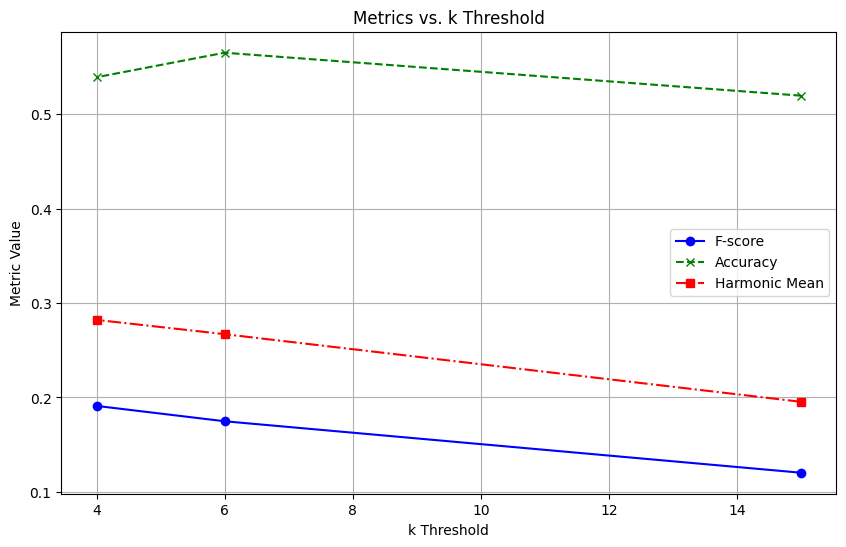

In [ ]:
# 3.1.2-B Classification-Acc VS k-threshold Line plot ------------------------

import matplotlib.pyplot as plt
import numpy as np

k_thresholds = [15, 6, 4]
accuracies = [0.51948, 0.564935, 0.538961]
f_scores = [0.12033, 0.17481, 0.19107]
harmonic_means = [0.19540, 0.26700, 0.28212]

# Generate the line plot
plt.figure(figsize=(10, 6))
plt.plot(k_thresholds, f_scores, marker='o', linestyle='-', color='b', label='F-score')
plt.plot(k_thresholds, accuracies, marker='x', linestyle='--', color='g', label='Accuracy')
plt.plot(k_thresholds, harmonic_means, marker='s', linestyle='-.', color='r', label='Harmonic Mean')
plt.xlabel('k Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. k Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Highlight the best k and corresponding accuracy
# best_k = k_thresholds[np.argmax(accuracies)]
# best_accuracy = np.max(accuracies)
# plt.scatter(best_k, best_accuracy, marker='o', color='r', s=100, label=f'Best k: {best_k}, Accuracy: {best_accuracy:.3f}')
# plt.legend()

plt.show()

### 3.3 Generation Task Testing & Evaluation

#### 3.3.1 Loading  In-Context Model and Prompt building

In [ ]:
# def free_memory():
#     import gc, torch, sys
#     from IPython import get_ipython

#     # --- Step 1: Delete large global variables ---
#     for name in [
#         "tokenised_passages", "eid2idx", "idx2eid", "bm25",
#         "emb", "dense_idx", "short_ids", "eid2dense",
#         "sbert", "bm25_retriever", "dense_retriever", "dense_reranker"
#     ]:
#         if name in globals():
#             globals()[name] = None
#             del globals()[name]

#     # --- Step 2: Garbage collect CPU memory ---
#     gc.collect()

#     # --- Step 3: Clear GPU cache ---
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#         torch.cuda.ipc_collect()

#     # --- Step 4: Delete modules from sys.modules (if dynamically imported) ---
#     for module in ["faiss", "datasets"]:
#         if module in sys.modules:
#             del sys.modules[module]

#     # --- Step 5: Clear interactive shell variables ---
#     ipython = get_ipython()
#     if ipython:
#         ipython.magic("reset -f")

#     # --- Final garbage collection ---
#     gc.collect()
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#         torch.cuda.ipc_collect()


In [ ]:
# free_memory()

In [ ]:
# # 2.2‑A  ·  Install deps & import
# !pip -q install transformers accelerate sentencepiece --upgrade
# # !pip install -U datasets
# from pathlib import Path
# import json, random, torch
# import time
# from transformers import AutoModelForCausalLM, AutoTokenizer

# # 1-A · SETUP ----------------------------------------------------------

# !pip -q install tqdm rank_bm25 sentence-transformers faiss-cpu datasets

# import json, re, os, gc, math, random, itertools, collections
# from pathlib import Path
# from tqdm.auto import tqdm
# import pandas as pd
# import json, numpy as np, torch, gc
# from rank_bm25 import BM25Okapi
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# from sentence_transformers import SentenceTransformer, CrossEncoder
# import faiss, numpy as np, torch
# import time
# import sys  # Import the sys module

# # Reproducibility
# SEED = 42
# random.seed(SEED); np.random.seed(SEED)

# import gdown

# # Create target folder
# !mkdir -p /content/COMP90042_2025/data

# # Download to correct location
# gdown.download(id='1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6',
#                output='/content/COMP90042_2025/data/evidence.json',
#                quiet=False)
# # 1-B : PATHS
# DATA_DIR = Path("/content/COMP90042_2025/data")
# TRAIN_PATH = DATA_DIR / "train-claims.json"
# DEV_PATH = DATA_DIR / "dev-claims.json"
# BASELINE_PATH = DATA_DIR / "dev-claims-baseline.json"
# EVID_PATH = DATA_DIR / "evidence.json"  # ✅ now using the real evidence file

# # Check all paths exist
# assert TRAIN_PATH.exists() and DEV_PATH.exists() and BASELINE_PATH.exists() and EVID_PATH.exists(), \
#     "Check that the dataset files are in DATA_DIR"

# # --- File Reader ---
# def read_json(path):
#     with open(path, encoding="utf-8") as f:
#         return json.load(f)

# # --- Load Data ---
# claims_train = read_json(TRAIN_PATH)
# claims_dev = read_json(DEV_PATH)
# claims_baseline = read_json(BASELINE_PATH)
# evidence_corpus = read_json(EVID_PATH)

# # --- Summary and Previews ---
# print("✔ Loaded Data Summary\n")

# # 1. Train Claims
# print("Train Claims:")
# print(f"  Total: {len(claims_train)}")
# sample_key = next(iter(claims_train))
# print(f"  Sample:\n{json.dumps(claims_train[sample_key], indent=4)}\n")

# # 2. Dev Claims
# print("Dev Claims:")
# print(f"  Total: {len(claims_dev)}")
# sample_key = next(iter(claims_dev))

# # 2.2‑B  ·  Config
# EVAL_DIR   = Path("/content/COMP90042_2025")
# PROC_DIR   = Path("/content")

# TRAIN_CLS  = PROC_DIR / "processed/train_cls_ver1.jsonl"
# DEV_CLS    = PROC_DIR / "processed/dev_cls_ver1.jsonl"


# model_id   = "google/flan-t5-large"

# MAX_INPUT  = 512          # token budget for prompt + query
# NUM_DEMOS  = 2         # how many in‑context examples
# random.seed(41)


# # 2.2-C  ·  LLM Loading and Inferencing Test (robust for seq2seq & causal LLMs)
# import torch
# from transformers import (
#     AutoConfig,
#     AutoTokenizer,
#     AutoModelForSeq2SeqLM,
#     AutoModelForCausalLM,
# )

# # 1) pick device
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"→ Using device: {DEVICE}")

# # 2) load config to determine model type
# config = AutoConfig.from_pretrained(model_id)
# is_encoder_decoder = getattr(config, "is_encoder_decoder", False)

# # 3) load & configure tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
# # many decoder-only models lack a pad token; use eos_token instead
# if tokenizer.pad_token_id is None:
#     tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
# tokenizer.truncation_side = "right"

# # 4) load appropriate model class
# ModelClass = AutoModelForSeq2SeqLM if is_encoder_decoder else AutoModelForCausalLM
# model = ModelClass.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
#     low_cpu_mem_usage=True,
# ).to(DEVICE).eval()

# # diagnostics
# print(" • model type       :", "seq2seq" if is_encoder_decoder else "causal")
# print(" • pad_token_id     :", tokenizer.pad_token_id)
# print(" • model device     :", next(model.parameters()).device)

# # 5) quick inference test
# prompt = (
#     "Given the claim and evidence, respond with one of: SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED.\n\n"
#     "Claim: The sun is hot.\n"
#     "Evidence: The sun emits thermal radiation.\n"
#     "Verdict:"
# )
# # tokenize *after* pad/truncation config
# inputs = tokenizer(
#     prompt,
#     return_tensors="pt",
#     truncation=True,
#     padding=True,
#     max_length=512,
# ).to(DEVICE)

# with torch.no_grad():
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=4,
#         pad_token_id=tokenizer.pad_token_id
#     )

# print("Prediction:", tokenizer.decode(outputs[0], skip_special_tokens=True))
# # 2.2‑D  ·  Load processed JSONL
# def read_jsonl(path):
#     with open(path) as f:
#         return [json.loads(line) for line in f]

# train_recs = read_jsonl(TRAIN_CLS)
# dev_recs   = read_jsonl(DEV_CLS)

# print(f"Loaded {len(train_recs)} train and {len(dev_recs)} dev examples")

# # ===============================================================
# # 2.2‑E · Prompt builder   (label‑balanced demos + robust parsing)
# # ===============================================================
# label_map = {0:"SUPPORTS", 1:"REFUTES",
#              2:"NOT_ENOUGH_INFO", 3:"DISPUTED"}
# REV_MAP   = {v:k for k,v in label_map.items()}

# # ---------- build label‑indexed pools once ---------------------
# EVID_TRIM_DEMO = 50          # words kept per demo evidence
# pools = {l: [] for l in range(4)}
# for rec in train_recs:
#     pools[rec["label_id"]].append(rec)

# def sample_demos(k=4):
#     """Return k demos containing **at least one of each label**."""
#     base = [random.choice(pools[i]) for i in range(4)]   # 4 labels
#     if k > 4:
#         others = random.sample(train_recs, k-4)
#         base.extend(others)
#     random.shuffle(base)
#     demos = []
#     for d in base[:k]:
#         e_txt = " ".join(" ".join(d["evidences"]).split()[:EVID_TRIM_DEMO])
#         demos.append((d["claim"], e_txt, label_map[d["label_id"]]))
#     return demos

# def build_prompt(demos, claim, evid):
#     header = (
#         "You are a fact‑checking assistant.\n"
#         "Classify the CLAIM given the EVIDENCE as exactly one word:\n"
#         "SUPPORTS, REFUTES, NOT_ENOUGH_INFO, or DISPUTED.\n"
#         "###\n"
#     )
#     blocks = [f"Claim: {c}\nEvidence:\n{e}\nAnswer: {lbl}\n###"
#               for c,e,lbl in demos]
#     query  = f"Claim: {claim}\nEvidence:\n{evid}\nAnswer:"
#     return header + "\n\n".join(blocks) + "\n\n" + query

# # ---------- robust safe‑label ---------------------------------
# import re
# _PAT = {0:r"\bSUPPORTS?\b",
#         1:r"\bREFUTES?\b",
#         2:r"\bNOT[_ ]?ENOUGH[_ ]?INFO\b|\bNEI\b",
#         3:r"\bDISPUTED?\b"}
# REGEX = {i: re.compile(p, re.I) for i,p in _PAT.items()}

# def safe_label(text: str) -> int:
#     for idx,rx in REGEX.items():
#         if rx.search(text):
#             return idx
#     return 2   # default to NEI if ambiguous



In [ ]:
# # ---------------------------------------------------------------
# # 0 · Paths, global opts
# # ---------------------------------------------------------------
# from pathlib import Path, PurePosixPath
# import json, torch, random, time, collections
# from tqdm import tqdm

# DATA_DIR = Path("/content/COMP90042_2025/data")

# TRAIN_PATH = DATA_DIR / "train-claims.json"
# DEV_PATH   = DATA_DIR / "dev-claims.json"
# TEST_PATH  = DATA_DIR / "test-claims-unlabelled.json"

# # previously built resources
# CLS_TRAIN  = Path("processed/train_cls_ver1.jsonl")
# CLS_DEV    = Path("processed/dev_cls_ver1.jsonl")

# random.seed(41)
# torch.manual_seed(41)


#### 3.3.2 Inferencing for Test Set

In [ ]:
# # ── label ↔ id maps ──────────────────────────────────────────
# label_map = {0: "SUPPORTS",
#              1: "REFUTES",
#              2: "NOT_ENOUGH_INFO",
#              3: "DISPUTED"}
# REV_MAP   = {v:k for k,v in label_map.items()}

In [ ]:
# # ===============================================================
# # Fast ICL inference with single generate() pass per batch
# # adapted for test_cls_ver2.jsonl format
# # ===============================================================
# import json, random, time, collections, torch, numpy as np
# from pathlib import Path
# from tqdm import tqdm

# # ── hyper-parameters ─────────────────────────────────────────────
# BATCH         = 4          # inference batch size
# VOTE_K        = 3          # self-consistency samples
# EVID_CAP      = 160        # words of evidence to keep in prompt
# TEMP, TOP_P   = 0.7, 0.9   # sampling parameters
# MARGIN_THRESH = 0.3       # override threshold → NOT_ENOUGH_INFO
# RUN_TAG       = time.strftime("%Y%m%d_%H%M%S")
# OUT_DIR       = Path("predictions"); OUT_DIR.mkdir(exist_ok=True)

# # ── label ↔ id maps (must match your safe_label & build_prompt) ──
# label_map = {
#     0: "SUPPORTS",
#     1: "REFUTES",
#     2: "NOT_ENOUGH_INFO",
#     3: "DISPUTED"
# }
# REV_MAP = {v:k for k,v in label_map.items()}

# # ── build reverse lookup from raw passage → evidence-id ───────────
# passage2eid = {txt.strip(): eid for eid, txt in evidence_corpus.items()}

# # ── precompute the first‐token ID for each label for margin scoring ─
# LABEL_TOKEN_ID = {
#     idx: tokenizer(lbl, add_special_tokens=False).input_ids[0]
#     for idx, lbl in label_map.items()
# }

# def _margin_from_vec(vec):
#     """Return difference between top‐1 and top‐2 label log‐probs."""
#     scores = [vec[LABEL_TOKEN_ID[i]].item() for i in range(4)]
#     top2   = sorted(scores, reverse=True)[:2]
#     return top2[0] - top2[1]

# # ===============================================================
# def run_icl(split_records, split_name):
#     """
#     split_records: list of dicts each with keys
#       • claim_id: string
#       • claim: str
#       • evidences: list of {"evidence_id", "evidence_text"}
#     split_name: "dev" or "test"
#     """
#     print(f"\n=== 🔹  {split_name.upper():<5} | {len(split_records)} claims ===")
#     preds = {}
#     buf_prompt, buf_rec = [], []
#     n_batches = (len(split_records) + BATCH - 1) // BATCH
#     p_bar = tqdm(total=n_batches, desc="Batches", ncols=90)

#     for rec in split_records:
#         # 1) extract IDs and texts from this record
#         cid = rec["claim_id"]
#         claim = rec["claim"]
#         ev_items = rec["evidences"]
#         # keep the IDs aside for the final output
#         ev_ids = [item["evidence_id"] for item in ev_items]
#         ev_texts = [item["evidence_text"] for item in ev_items]

#         # 2) build the in-context prompt
#         demo_list = sample_demos(4)   # ensure at least one of each label
#         evid_for_prompt = " ".join(" ".join(ev_texts).split()[:EVID_CAP])
#         prompt = build_prompt(demo_list, claim, evid_for_prompt)

#         buf_prompt.append(prompt)
#         buf_rec.append((cid, claim, ev_ids))

#         # 3) once batch is full or at end, fire the model
#         last = (len(buf_prompt) == BATCH or
#                 (len(preds) + len(buf_prompt)) == len(split_records))
#         if not last:
#             continue

#         inputs = tokenizer(
#             buf_prompt,
#             return_tensors="pt",
#             padding="longest",
#             truncation=True,
#             max_length=MAX_INPUT
#         ).to(DEVICE)

#         with torch.no_grad():
#             out = model.generate(
#                 **inputs,
#                 do_sample=True,
#                 temperature=TEMP,
#                 top_p=TOP_P,
#                 num_return_sequences=VOTE_K,
#                 max_new_tokens=4,
#                 pad_token_id=tokenizer.pad_token_id,
#                 return_dict_in_generate=True,
#                 output_scores=True
#             )

#         # sequences: (BATCH*VOTE_K, seq_len); logits: first-token scores
#         seqs   = out.sequences
#         logits = out.scores[0]

#         # 4) decode each example in the batch
#         B_cur = len(buf_prompt)
#         for b in range(B_cur):
#             start, end = b * VOTE_K, (b + 1) * VOTE_K

#             # majority vote
#             answers = [
#                 safe_label(tokenizer.decode(s, skip_special_tokens=True))
#                 for s in seqs[start:end]
#             ]
#             maj = collections.Counter(answers).most_common(1)[0][0]

#             # margin override → NOT_ENOUGH_INFO
#             if _margin_from_vec(logits[start]) < MARGIN_THRESH:
#                 maj = REV_MAP["NOT_ENOUGH_INFO"]

#             # pack into preds
#             cid_b, claim_b, ev_ids_b = buf_rec[b]
#             preds[cid_b] = {
#                 "claim_text":  claim_b,
#                 "claim_label": label_map[maj],
#                 "evidences":   ev_ids_b
#             }

#         # clear buffers and advance progress bar
#         buf_prompt.clear()
#         buf_rec.clear()
#         p_bar.update(1)

#     p_bar.close()
#     out_path = OUT_DIR / f"{split_name}-preds-{RUN_TAG}.json"
#     out_path.write_text(json.dumps(preds, indent=2))
#     print(f"✓ Saved {split_name} predictions ➜ {out_path}\n")
#     return out_path

# # ---------------------------------------------------------------
# # DEV sanity-check (uncomment if desired)
# # dev_preds = run_icl(dev_recs, "dev")

# # ---------------------------------------------------------------
# # TEST inference
# test_recs = []
# with Path("processed/test_cls_ver2.jsonl").open() as f:
#     for line in f:
#         obj = json.loads(line)
#         # rename field for consistency
#         obj["claim_id"] = obj.get("claim_id", f"claim-{len(test_recs)}")
#         test_recs.append(obj)

# # produce and save final test predictions JSON
# test_preds = run_icl(test_recs, "test")
